# Deep Learning - Knowledge Distillation (KD) of Handwritten Digit Calculator 

In [ ]:
"""
MIT License

Copyright (c) 2019 wblachowski

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


Link to dataset: https://github.com/wblachowski/bhmsds?fbclid=IwAR2WbJRLMxecP4a41iTjJR-_idug6anFvjFdz8XyinaZV7gA8OFwaah7MR8
"""

import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import cv2
import os, os.path
import matplotlib.pyplot as plt                                     
import imutils                                                      #contours
import random

from torch.utils.data import Dataset, DataLoader, random_split
!pip install torchinfo
from torchinfo import summary                                       #network description 
from sympy import *                                                 #symbolic mathematics
from google.colab import files
from google.colab.patches import cv2_imshow

#use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#labels  
LABELS_DICT = {
    '0' : 0,
    '1' : 1,
    '2' : 2,
    '3' : 3,
    '4' : 4,
    '5' : 5,
    '6' : 6,
    '7' : 7,
    '8' : 8,
    '9' : 9,
    'plus' : 10,
    'minus' : 11,
    'slash' : 12,
    'dot' : 13,
    'w' : 14,
    'x' : 15,
    'y' : 16,
    'z' : 17,
    }

INV_LABELS_DICS = {v: k for k, v in LABELS_DICT.items()}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Streaming af output blev afkortet til de sidste 5000 linjer.
 extracting: ./bhmsds-master/symbols/w-1000.png  
 extracting: ./bhmsds-master/symbols/w-1001.png  
 extracting: ./bhmsds-master/symbols/w-1002.png  
 extracting: ./bhmsds-master/symbols/w-1003.png  
 extracting: ./bhmsds-master/symbols/w-1004.png  
 extracting: ./bhmsds-master/symbols/w-1005.png  
 extracting: ./bhmsds-master/symbols/w-1006.png  
 extracting: ./bhmsds-master/symbols/w-1007.png  
  inflating: ./bhmsds-master/symbols/w-1008.png  
 extracting: ./bhmsds-master/symbols/w-1009.png  
 extracting: ./bhmsds-master/symbols/w-1010.png  
  inflating: ./bhmsds-master/symbols/w-1011.png  
  inflating: ./bhmsds-master/symbols/w-1012.png  
  inflating: ./bhmsds-master/symbols/w-1013.png  
  inflating: ./bhmsds-master/symbols/w-1014.png  
  inflating: ./bhmsds-master/symbols/w-1015.png  
 extracting: ./bhmsds-master/symbols/w-1016.png  
 extracting: ./bhmsds-master/symbols/w-1017.png  
 extracting: ./bhmsds-master/symbols/w-

TypeError: ignored

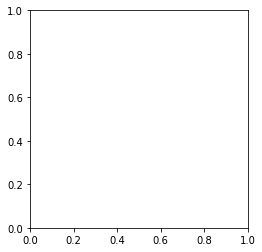

In [ ]:
"""
CREATING CUSTOM DATASET
Data consist of: 
- Numbers from 1-9
- Operators: +, -, / and * 
- Letters: w, x, y, z

- Format of each image: <symbol-name>-<id>.png
- 1500 images of each type 
"""

class Digits(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    #function to resize image to same dimensions 
    def convert(self, img_path):
        image = cv2.imread(img_path)
        #image = cv2.resize(image, (32, 32))      
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting from bgr to grayscale for faster computation 
        _ , image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

        if self.transform:
            image = self.transform(image) 

            #normalizing tensor
            mean, std = torch.mean(image), torch.std(image)
            normalize = transforms.Normalize(mean, std)
            image = normalize(image)

        return image

    #function to get image label
    def get_label(self, filename):
        label_name = filename.split("-")
        label = LABELS_DICT[label_name[0]]

        if self.target_transform:
            label = self.target_transform(label)
        
        return label

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        #getting image path
        filename = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, filename)
        
        #get image and corresponding label
        label = self.get_label(filename)
        image = self.convert(img_path)
        
        return image, label
    

#get data
uploaded = files.upload()
!unzip bhmsds-master.zip -d ./

#set up dataset
transform = transforms.Compose([transforms.ToTensor()]) 

dataset = Digits("/content/bhmsds-master/symbols", transform=transform)     #google colab
#dataset = Digits("data/symbols/", transform=transform)                     #otherwise use this

datasetSize = dataset.__len__()
batch_size = 2 

#split data: 80% training, 10% validation, 10% test
test_train_data, test_validation_data, test_test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])

#creating data loaders
test_trainloader = DataLoader(test_train_data, batch_size=batch_size, shuffle=True, num_workers=0)


"""
GETTING SOME IMAGES FROM DATASET (Google colab has problem showing the images - code works in visual studio code)
"""
dataiter = iter(test_trainloader)
images, labels = next(dataiter)

#run through 5 batches
for i in range(5): 
    images, labels = next(dataiter)
    for image, label in zip(images, labels): # Run through all samples in a batch
        plt.figure()
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap="gray")
        plt.title(label)


In [ ]:
"""
PREPARING DATA FOR TRAINING
"""
#normalizing data and one-hot encode
transform = transforms.Compose([transforms.ToTensor()])  

#create data
dataset = Digits("/content/bhmsds-master/symbols", transform=transform)
datasetSize = dataset.__len__()

batch_size = 128 

#split data: 80% training, 10% validation, 10% test
train_data, validation_data, test_data = random_split(dataset, [datasetSize - int(0.2 * datasetSize), int(0.1 * datasetSize), int(0.1 * datasetSize)])
#train_data, validation_data, test_data = random_split(dataset, [6500, 500, 20000])

#creating data loaders
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validateloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
"""
KNOWLEDGE DISTILLIATION NETWORK
The basic idea behind Knowledge Distillation is that you define a Teacher (which can be a single model or an ensemble) and a 
Student ( Which is the lightweight model you want to use in production), 
then you train the Teacher on the target task and have the Student try to mimic the Teacher.

Steps:
1. Define and train a large network (teacher)
2. Define and train a small network (student)
3. Distillation training of the small netwrok using only the teacher's soft targets 
"""
class Teacher(nn.Module):
    def __init__(self, num_classes):
        super(Teacher, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same', bias=True)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding="same", bias=True)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding="same", bias=True)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten()
        self.conv2_drop = nn.Dropout2d() #dropout (type of regularization) avoids overfitting
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.bn4 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn5 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, num_classes)        
    
    def forward(self, x):
        x = self.conv1(x)   #[batch size, 32, 28, 28]
        x = self.bn1(x)
        x = self.pool1(x)   #[batch size, 32, 14, 14]
        x = F.relu(x)
        x = self.conv2(x)   #[batch size, 32, 28, 28]
        x = self.bn2(x)
        x = self.pool2(x)   #[batch size, 32, 7, 7]
        x = F.relu(x)
        x = self.conv3(x)   #[batch size, 64, 7, 7]
        x = self.bn3(x)
        x = self.pool3(x)   #[batch size, 64, 3, 3]
        x = F.relu(x)
        x = self.flatten(x) #[batch size, 64 * 3 * 3]
        x = self.conv2_drop(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Student(nn.Module):
  def __init__(self, input_size, num_classes):
    super(Student, self).__init__()
    self.fc1 = nn.Linear(input_size, 30)
    self.fc2 = nn.Linear(30, num_classes)

  def forward(self, x):
    x = x.view(-1, 784)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x


#testing model 
testTeacherNetwork = Teacher(len(LABELS_DICT)).to(device)
print(summary(testTeacherNetwork, (1, 1, 28, 28)))

testStudentNetwork = Student(784, len(LABELS_DICT)).to(device)
print(summary(testStudentNetwork, (1, 1, 28, 28)))


"""
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

print(len(example_data))
print(example_data.shape)
"""

Layer (type:depth-idx)                   Output Shape              Param #
Teacher                                  [1, 18]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           9,248
├─BatchNorm2d: 1-5                       [1, 32, 14, 14]           64
├─MaxPool2d: 1-6                         [1, 32, 7, 7]             --
├─Conv2d: 1-7                            [1, 64, 7, 7]             18,496
├─BatchNorm2d: 1-8                       [1, 64, 7, 7]             128
├─MaxPool2d: 1-9                         [1, 64, 3, 3]             --
├─Flatten: 1-10                          [1, 576]                  --
├─Dropout2d: 1-11                        [1, 576]                  --
├─Linear: 1-12                           [1, 120]                  69,240
├─

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


'\nexamples = enumerate(trainloader)\nbatch_idx, (example_data, example_targets) = next(examples)\n\nprint(len(example_data))\nprint(example_data.shape)\n'

In [ ]:
"""
TRAINING METHOD
"""
#lists to hold accuracy and loss - used for plotting 
training_losses = []
training_accuracy = []
student_training_losses = []
student_training_accuracy = []

def train(network, trainloader, optimizer, criterion, device, modelType):
    #variables accuracy and loss 
    size, batch_size = 0, 0
    training_correct, correct = 0, 0 

    #setting network to training mode 
    network.to(device)
    network.train()
    
    #training the model
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        #calculate predictions and loss
        output = network(data)
        loss = criterion(output, target)

        #backpropagate
        optimizer.zero_grad()   #1. sets gradients to zero
        loss.backward()         #2. compute new gradients using back propagation
        optimizer.step()        #3. update parameters with new gradients 

        #computing accuracy 
        correct = (output.argmax(1) == target).type(torch.float).sum().item()
        training_correct += correct
        batch_size = len(data)

        #store accuracy and loss
        if modelType == 1:
          training_losses.append(loss.item())
          training_accuracy.append(correct / batch_size)

        if modelType == 2:
          student_training_losses.append(loss.item())
          student_training_accuracy.append(correct/batch_size)

        #updating size
        size += batch_size
        
        #print out loss data
        if(batch_idx % 25 == 0):
            print("[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(batch_idx * len(data),
                                                            len(trainloader.dataset),
                                                            100. * batch_idx / len(trainloader), 
                                                            loss.item()))
    #save internal state
    if modelType == 1:
        torch.save(network.state_dict(), "model_teacher.pth")

    if modelType == 2:
        torch.save(network.state_dict(), "model_student.pth")
    
    #print training accuracy 
    training_correct = training_correct / size 

    print(f"Training accuracy: {(100 * training_correct):>0.1f}%")
    

In [ ]:
"""
VALIDATION METHOD
"""
#lists to hold accuracy and loss - used for plotting 
validate_losses = []
validate_accuracy = []
student_validate_losses = []
student_validate_accuracy = []

def validate(network, validationloader, criterion, device, modelType):
    #variables
    size, batch_size = 0, 0
    validation_loss, loss = 0, 0
    validation_correct, correct = 0, 0

    num_batches = len(validationloader)

    #set network to testing mode
    network.to(device)
    network.eval()

    #validating the model 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validationloader):
            data, target = data.to(device), target.to(device)

            #getting batch size 
            batch_size = len(data)

            #predicting the output 
            output = network(data)

            #loss 
            loss = criterion(output, target)
            validation_loss += loss.item()
            
            #accuracy
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            validation_correct += correct

            #store accuracy and loss 
            if modelType == 1:
              validate_losses.append(loss.item())
              validate_accuracy.append(correct / batch_size)
            
            if modelType == 2:
              student_validate_losses.append(loss.item())
              student_validate_accuracy.append(correct / batch_size)
             
            #updating size
            size += batch_size
        
    #calculate loss 
    validation_loss = validation_loss / num_batches

    #calculate accuracy   
    validation_correct = validation_correct / size

    #printing output of validation  
    print(f"Validation set: \n Accuracy: {(100 * validation_correct):>0.1f}%, Average loss: {validation_loss:>8f} \n")

In [ ]:
"""
TRAINING TEACHER AND STUDENT SEPARATELY 
"""
epochs = 10
num_classes = len(LABELS_DICT)
learning_rate = 0.01 
momentum = 0.5
input_size = 784 

student = Student(input_size, num_classes=num_classes)
teacher = Teacher(num_classes=num_classes)

#using adam
optimizer_student = optim.Adam(student.parameters(), lr=learning_rate)
optimizer_teacher = optim.Adam(teacher.parameters(), lr=learning_rate)

#using sgd
#optimizer_student = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)
#optimizer_teacher = optim.SGD(teacher.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.functional.cross_entropy   #default loss function for multi-class classifications problems         


#training and validating the teacher
for iEpoch in range(epochs): 
  print(f"Epoch {iEpoch + 1}\n--------------------")
  
  train(teacher, trainloader, optimizer_teacher, criterion, device, 1)
  validate(teacher, validateloader, criterion, device, 1)


#training and validating the student
for iEpoch in range(epochs): 
  print(f"Epoch {iEpoch + 1}\n--------------------")
  
  train(student, trainloader, optimizer_student, criterion, device, 2)
  validate(student, validateloader, criterion, device, 2)



Epoch 1
--------------------
[0/21600 (0%)]	Loss: 2.912785
[3200/21600 (15%)]	Loss: 0.603546
[6400/21600 (30%)]	Loss: 0.344881
[9600/21600 (44%)]	Loss: 0.280447
[12800/21600 (59%)]	Loss: 0.214706
[16000/21600 (74%)]	Loss: 0.284566
[19200/21600 (89%)]	Loss: 0.147901
Training accuracy: 88.3%
Validation set: 
 Accuracy: 96.6%, Average loss: 0.098017 

Epoch 2
--------------------
[0/21600 (0%)]	Loss: 0.117444
[3200/21600 (15%)]	Loss: 0.165328
[6400/21600 (30%)]	Loss: 0.108288
[9600/21600 (44%)]	Loss: 0.139994
[12800/21600 (59%)]	Loss: 0.132448
[16000/21600 (74%)]	Loss: 0.100161
[19200/21600 (89%)]	Loss: 0.150817
Training accuracy: 95.4%
Validation set: 
 Accuracy: 97.2%, Average loss: 0.081150 

Epoch 3
--------------------
[0/21600 (0%)]	Loss: 0.154650
[3200/21600 (15%)]	Loss: 0.054226
[6400/21600 (30%)]	Loss: 0.071031
[9600/21600 (44%)]	Loss: 0.118482
[12800/21600 (59%)]	Loss: 0.041958
[16000/21600 (74%)]	Loss: 0.189985
[19200/21600 (89%)]	Loss: 0.069669
Training accuracy: 96.5%
Validat

In [ ]:
"""
KNOWLEDGE DISTILLATION CUSTOM LOSS FUNCTION  
"""
def criterion_kd(outputs, targets, teacher_outputs, temperature=4, alpha=0.5):
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/temperature, dim=1),
                             F.softmax(teacher_outputs / temperature, dim=1)) * (alpha * (temperature * temperature)) + \
              F.cross_entropy(outputs, targets) * (1. - alpha)

    return KD_loss


"""
KNOWLEDGE DISTILLATION TRAINING FUNCTION 
"""
#variables to keep track of loss and accuracy
kd_train_accuracy = []
kd_train_loss = []

def kd_train(student_network, teacher_network, trainloader, optimizer, device):
    size, batch_size = 0, 0
    training_correct, correct = 0, 0

    #student training is based on outputs from teacher -> student in training mode & teacher in eval mode 
    student_network.to(device)
    student_network.train()

    teacher_network.to(device)
    teacher_network.eval()

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)

        #get outputs for student and teacher
        outputs_student = student_network(data)
        outputs_teacher = teacher_network(data)
        
        prediction = outputs_student.argmax(dim=1, keepdim=True)

        #calculate from custom loss 
        loss_kd = criterion_kd(outputs_student, target, outputs_teacher)

        #backpropagation
        optimizer.zero_grad()
        loss_kd.backward()
        optimizer.step()

        #computing accuracy 
        correct =  prediction.eq(target.view_as(prediction)).sum().item()
        training_correct += correct
        batch_size = len(data)

        #storing loss 
        kd_train_loss.append(loss_kd.item())
        kd_train_accuracy.append(correct / batch_size)

        #updating size
        size += batch_size
        
        #print out loss data
        if(batch_idx % 25 == 0):
            print("[{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(batch_idx * len(data),
                                                            len(trainloader.dataset),
                                                            100. * batch_idx / len(trainloader), 
                                                            loss_kd.item()))
    #save internal state of model 
    torch.save(student_network.state_dict(), "model_new_student.pth")

    #calculate training accuracy 
    training_correct = training_correct / size 

    print(f"Training accuracy: {(100 * training_correct):>0.1f}%")



"""
KNOWLEDGE DISTILLATION VALIDATION FUNCTION 
"""
kd_validate_accuracy = []
kd_validate_loss = []

def kd_validate(student_network, criterion, validationloader, device):
    #variables
    size, batch_size = 0, 0
    validation_loss, loss = 0, 0
    validation_correct, correct = 0, 0

    num_batches = len(validationloader)

    #set network to testing mode
    student_network.to(device)
    student_network.eval()

    #validating the model 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validationloader):
            data, target = data.to(device), target.to(device)

            #getting batch size 
            batch_size = len(data)

            #predicting the output 
            outputs = student_network(data)
            predictions = outputs.argmax(dim=1, keepdim=True)

            #loss 
            loss = criterion(outputs, target)
            validation_loss += loss.item()
            kd_validate_loss.append(loss.item())

            #accuracy
            correct = predictions.eq(target.view_as(predictions)).sum().item()
            validation_correct += correct
            kd_validate_accuracy.append(correct / batch_size)

            #updating size
            size += batch_size
        
    #calculate loss 
    validation_loss = validation_loss / num_batches

    #calculate accuracy   
    validation_correct = validation_correct / size

    #printing output of validation  
    print(f"Validation set: \n Accuracy: {(100 * validation_correct):>0.1f}%, Average loss: {validation_loss:>8f} \n")



In [ ]:
"""
TRAINING KD NETWORK
"""
#making new instance of student network 
new_student = Student(784, num_classes=num_classes)
optimizer_new_student = optim.Adam(new_student.parameters(), lr=learning_rate)

#run the training 
for iEpoch in range (epochs):
    print(f"Epoch {iEpoch + 1}\n--------------------")

    kd_train(new_student, teacher, trainloader, optimizer_new_student, device)
    kd_validate(new_student, criterion, validateloader, device)

Epoch 1
--------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[0/21600 (0%)]	Loss: 2.240856
[3200/21600 (15%)]	Loss: 0.570495
[6400/21600 (30%)]	Loss: 0.505335
[9600/21600 (44%)]	Loss: 0.390026
[12800/21600 (59%)]	Loss: 0.277666
[16000/21600 (74%)]	Loss: 0.364926
[19200/21600 (89%)]	Loss: 0.358284
Training accuracy: 84.3%
Validation set: 
 Accuracy: 89.4%, Average loss: 0.359817 

Epoch 2
--------------------
[0/21600 (0%)]	Loss: 0.250586
[3200/21600 (15%)]	Loss: 0.247108
[6400/21600 (30%)]	Loss: 0.217234
[9600/21600 (44%)]	Loss: 0.314229
[12800/21600 (59%)]	Loss: 0.219867
[16000/21600 (74%)]	Loss: 0.218974
[19200/21600 (89%)]	Loss: 0.276062
Training accuracy: 92.5%
Validation set: 
 Accuracy: 91.1%, Average loss: 0.358279 

Epoch 3
--------------------
[0/21600 (0%)]	Loss: 0.189928
[3200/21600 (15%)]	Loss: 0.248745
[6400/21600 (30%)]	Loss: 0.159070
[9600/21600 (44%)]	Loss: 0.149216
[12800/21600 (59%)]	Loss: 0.238401
[16000/21600 (74%)]	Loss: 0.183439
[19200/21600 (89%)]	Loss: 0.206858
Training accuracy: 94.5%
Validation set: 
 Accuracy: 91.0%, A

<Figure size 720x720 with 0 Axes>

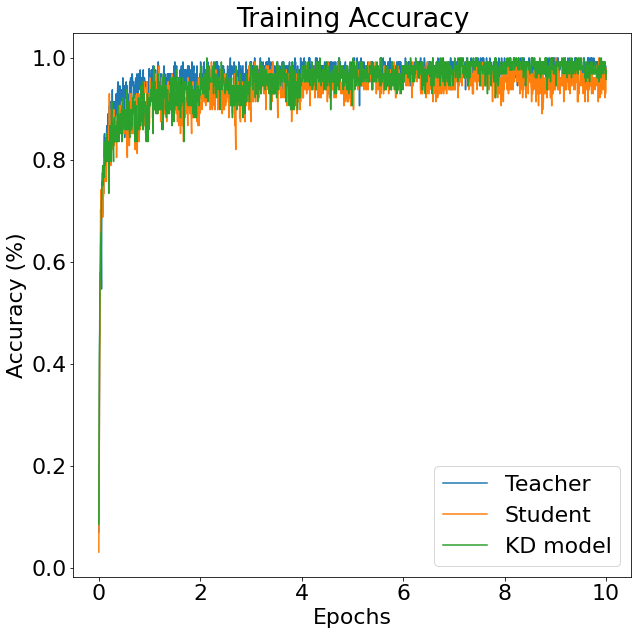

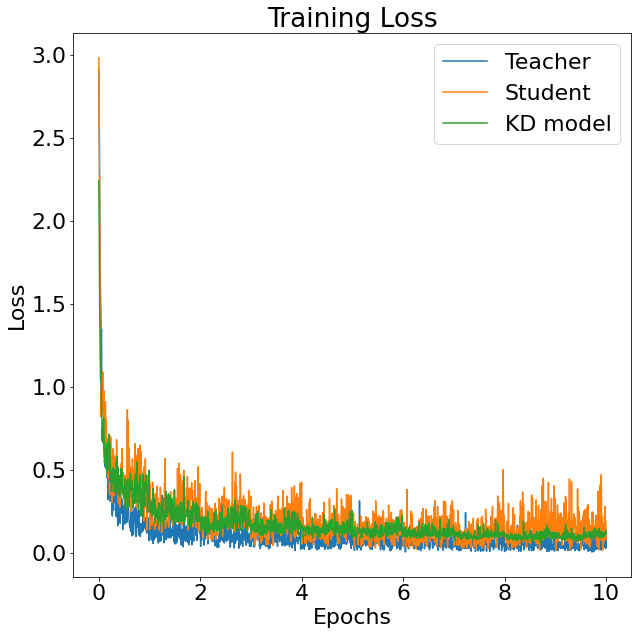

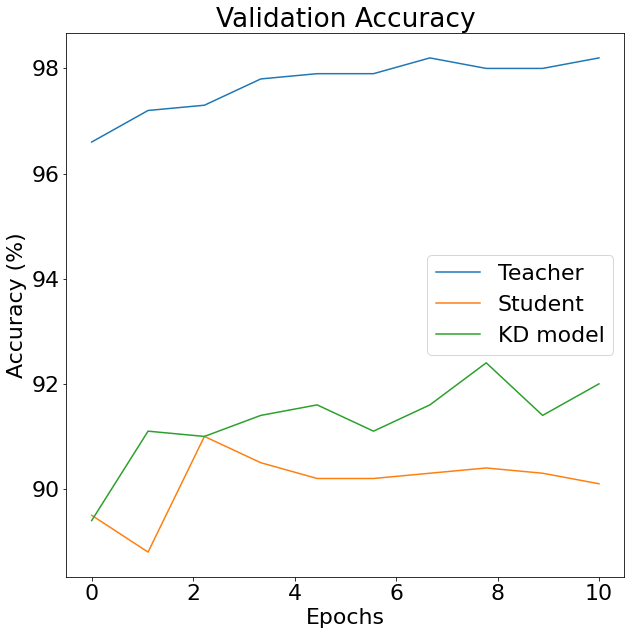

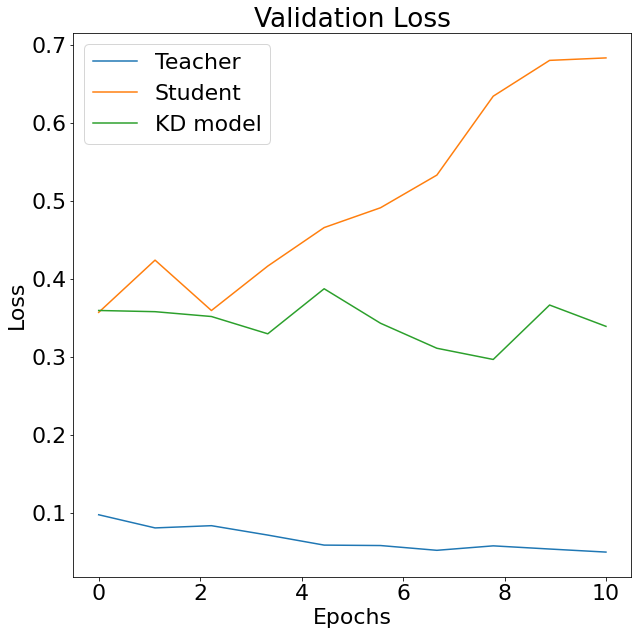

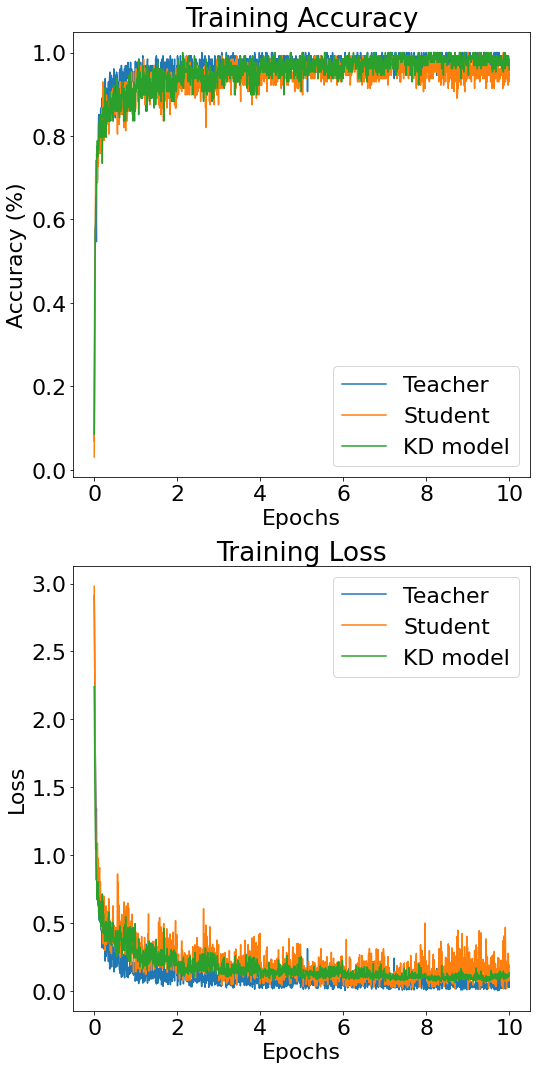

In [89]:
"""
PLOTTING RESULTS
"""
#change font size for plotting 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rcParams.update({'font.size': 22})


# x values (epochs)
epochs_training = np.linspace(0, epochs, len(training_accuracy))
epochs_validation = np.linspace(0, epochs, len(validate_accuracy))


#variables to store avg validation loss and accuracy 
average_validation_loss_teacher = [0.098017, 0.081150, 0.084012, 0.071976, 0.059117, 0.058566, 0.052444, 0.058161, 0.054100, 0.050165]
average_validation_loss_student = [0.357416, 0.424356 , 0.359764, 0.416732, 0.466068, 0.491474, 0.533345, 0.634467, 0.680360, 0.683523]
average_validation_loss_new_student = [0.359817, 0.358279, 0.352091, 0.329924, 0.387653, 0.343457, 0.311415, 0.297049, 0.366808, 0.339484]

average_validation_accuracy_teacher = [96.6, 97.2, 97.3, 97.8, 97.9, 97.9, 98.2, 98.0, 98.0, 98.2]
average_validation_accuracy_student = [89.5, 88.8, 91.0, 90.5, 90.2, 90.2, 90.3, 90.4, 90.3, 90.1]
average_validation_accuracy_new_student = [89.4, 91.1, 91.0, 91.4, 91.6, 91.1, 91.6, 92.4, 91.4, 92.0]


#training accuracy 
figure = plt.figure(figsize=(10, 10)) 
plt.plot(epochs_training, training_accuracy, label='Teacher') 
plt.plot(epochs_training, student_training_accuracy, label='Student') 
plt.plot(epochs_training, kd_train_accuracy, label='KD model') 
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig('training_accuracy.png')


#training loss 
figure = plt.figure(figsize=(10, 10)) 
plt.plot(epochs_training, training_losses, label='Teacher') 
plt.plot(epochs_training, student_training_losses, label='Student') 
plt.plot(epochs_training, kd_train_loss, label='KD model') 
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('training_loss.png')


#validation accuracy 
figure = plt.figure(figsize=(10, 10)) 
plt.plot(epochs_validation, average_validation_accuracy_teacher, label='Teacher') 
plt.plot(epochs_validation, average_validation_accuracy_student, label='Student') 
plt.plot(epochs_validation, average_validation_accuracy_new_student, label='KD model') 
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig('avg_validation_accuracy.png')

#validation loss 
figure = plt.figure(figsize=(10, 10)) 
plt.plot(epochs_validation, average_validation_loss_teacher, label='Teacher')
plt.plot(epochs_validation, average_validation_loss_student, label='Student') 
plt.plot(epochs_validation, average_validation_loss_new_student, label='KD model') 
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('avg_validation_loss.png')


#add both training and accuracy in one graph
figure = plt.figure(figsize=(18, 18)) 
figure.add_subplot(2, 2, 1)
plt.plot(epochs_training, training_accuracy, label='Teacher') 
plt.plot(epochs_training, student_training_accuracy, label='Student')  
plt.plot(epochs_training, kd_train_accuracy, label='KD model') 
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

figure.add_subplot(2, 2, 3)
plt.plot(epochs_training, training_losses, label='Teacher') 
plt.plot(epochs_training, student_training_losses, label='Student') 
plt.plot(epochs_training, kd_train_loss, label='KD model') 
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('combine_training_loss.png')

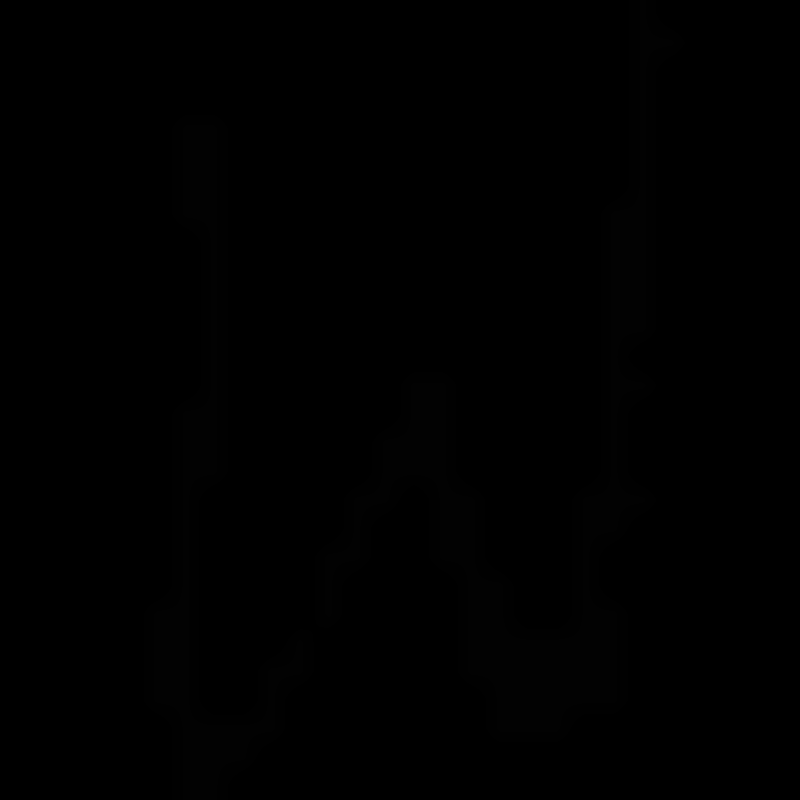

Target label:  14
Predicted label:  14


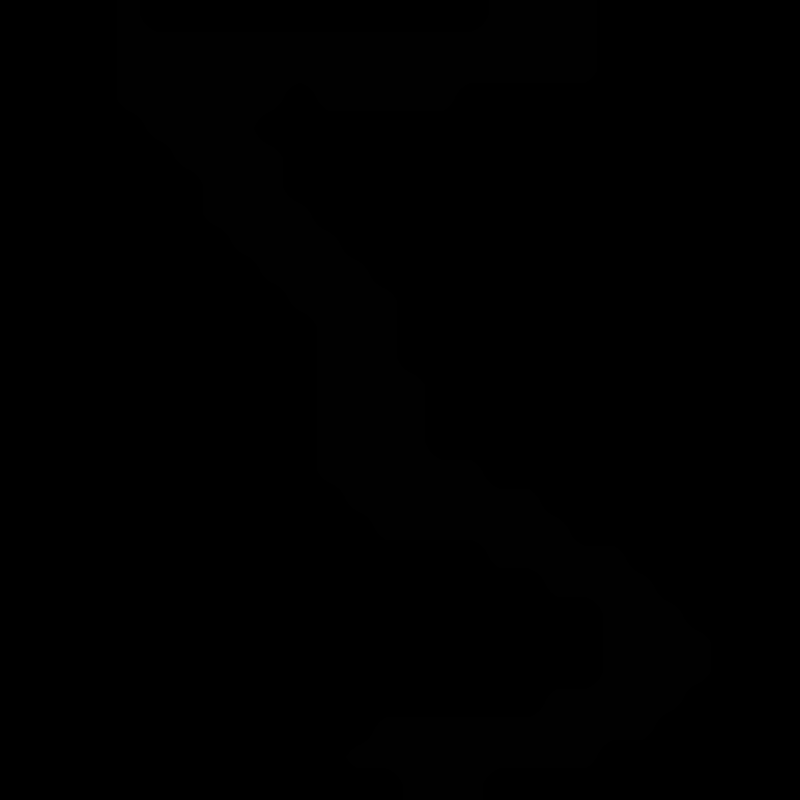

Target label:  5
Predicted label:  5


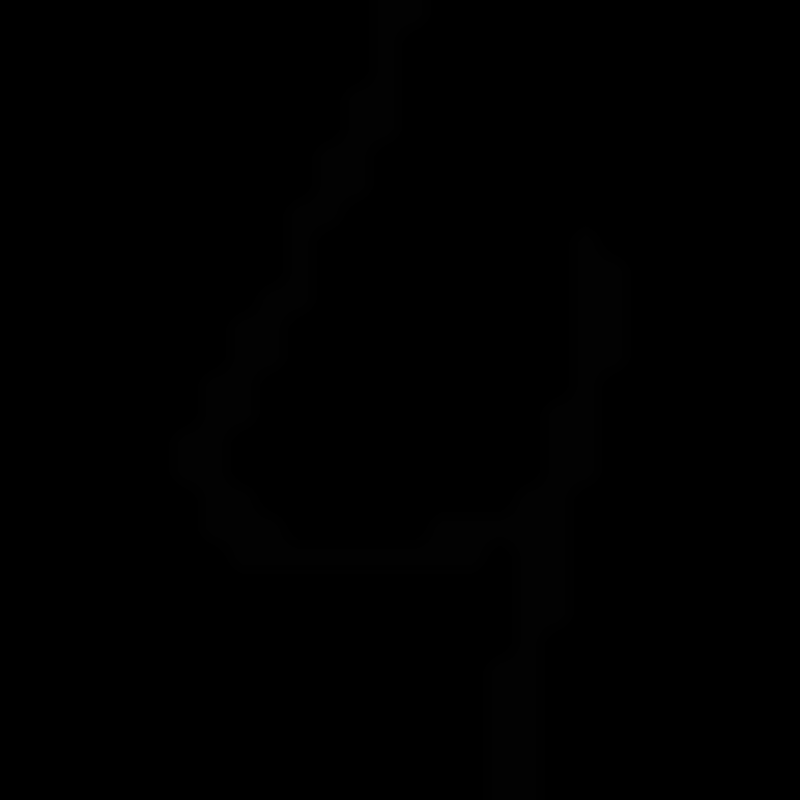

Target label:  4
Predicted label:  4


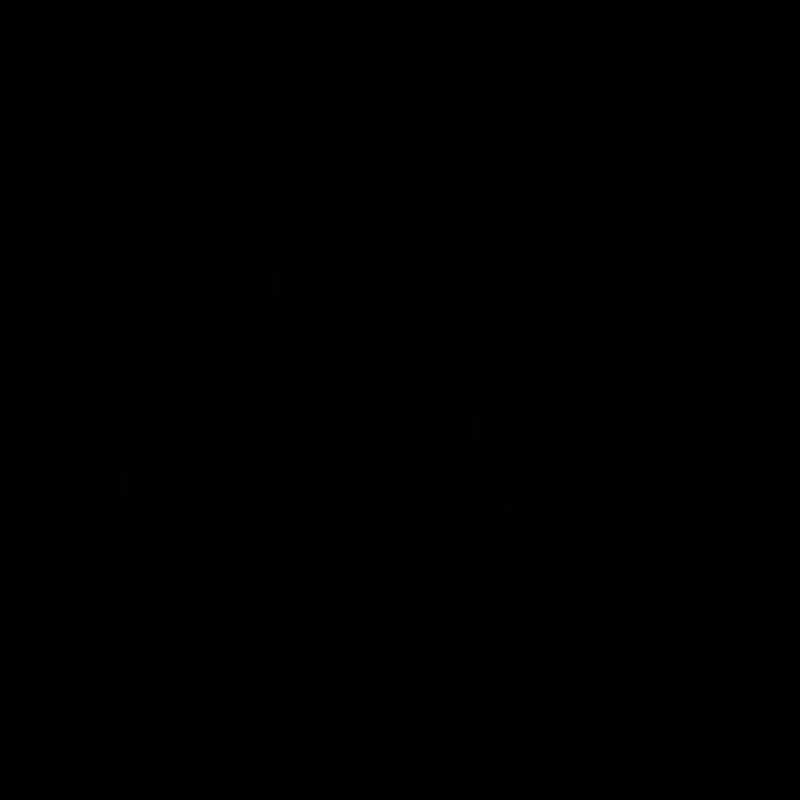

Target label:  15
Predicted label:  15


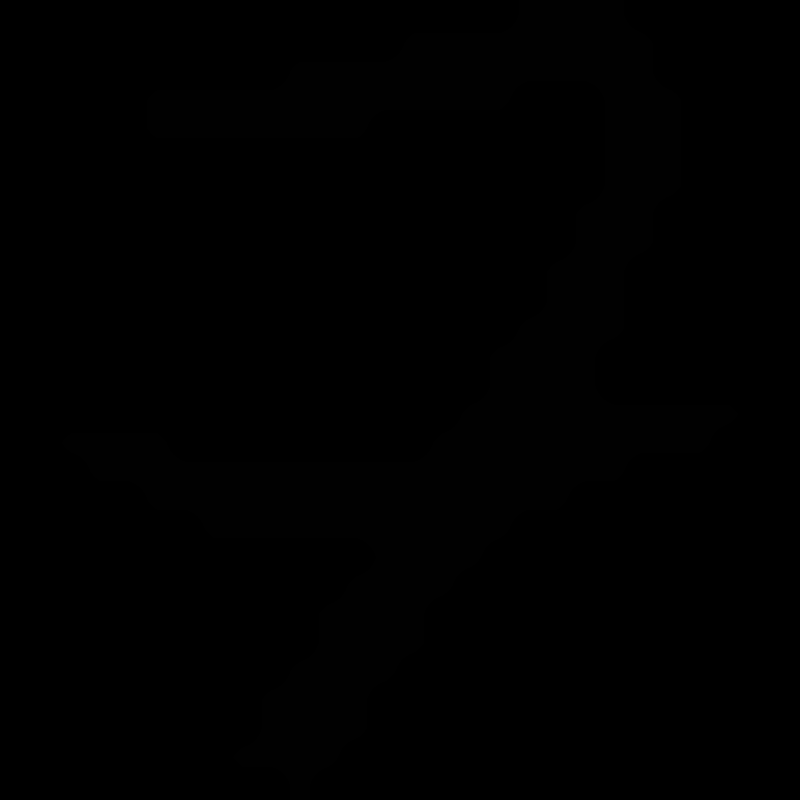

Target label:  7
Predicted label:  7


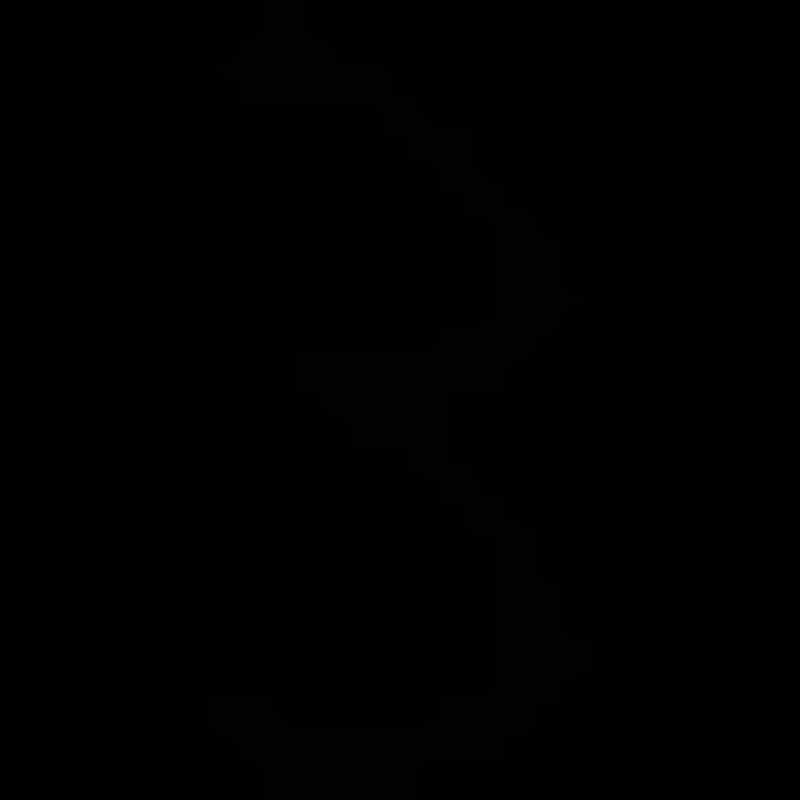

Target label:  3
Predicted label:  16


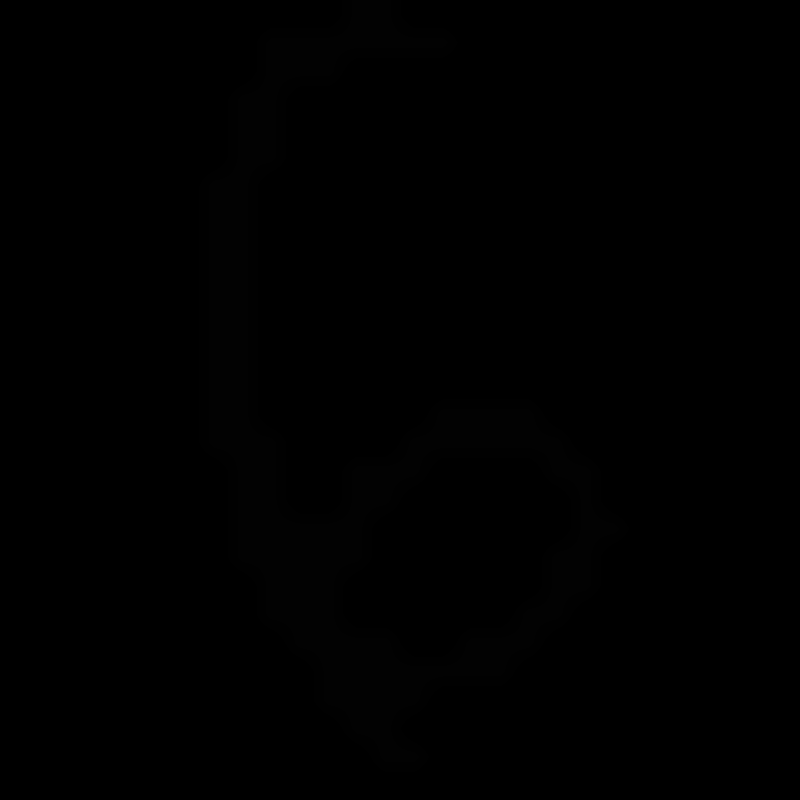

Target label:  6
Predicted label:  6


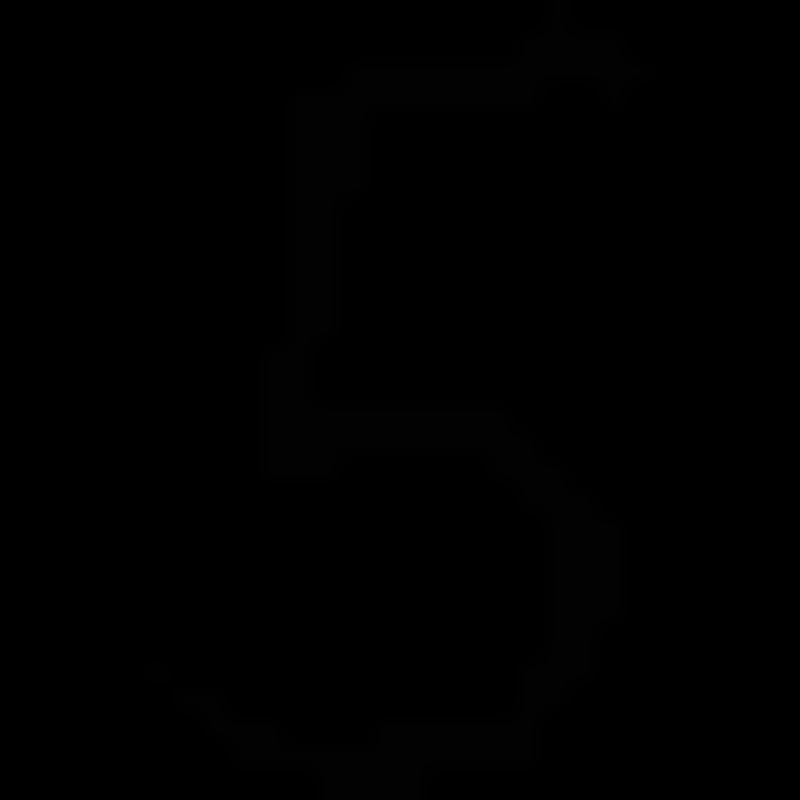

Target label:  5
Predicted label:  5


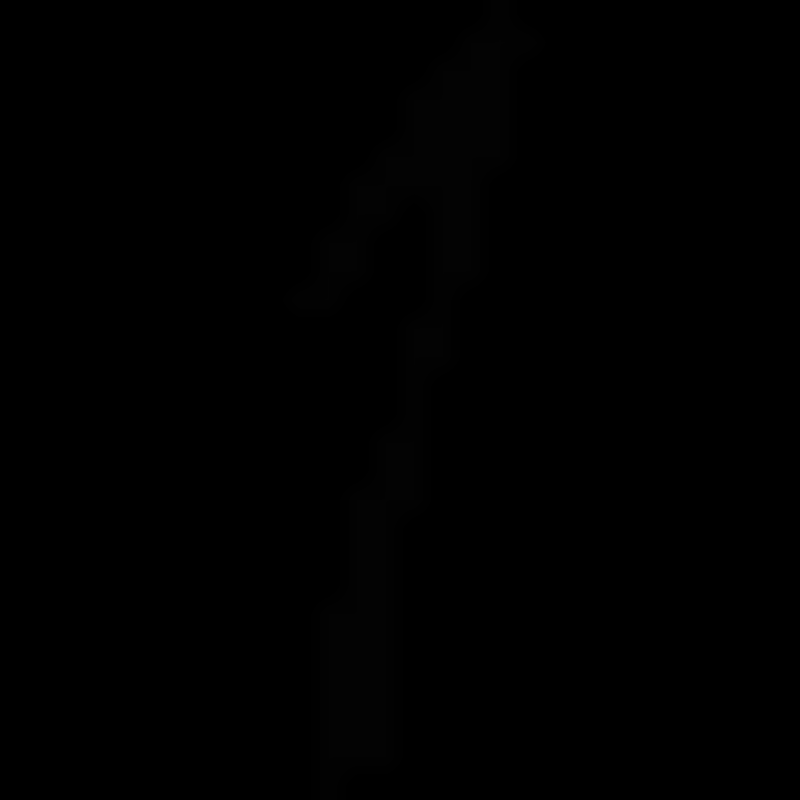

Target label:  1
Predicted label:  1


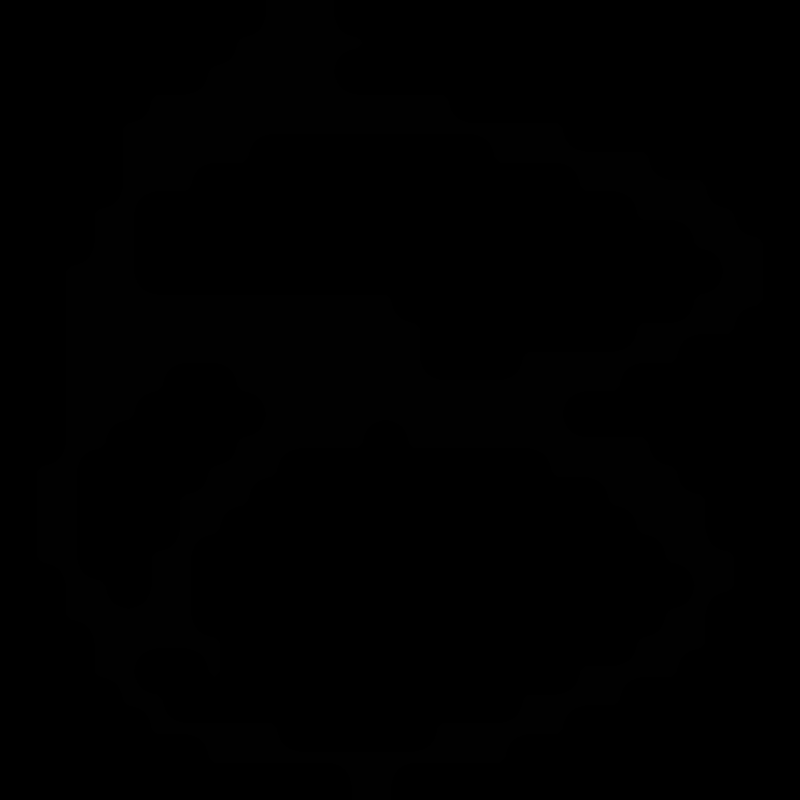

Target label:  8
Predicted label:  0


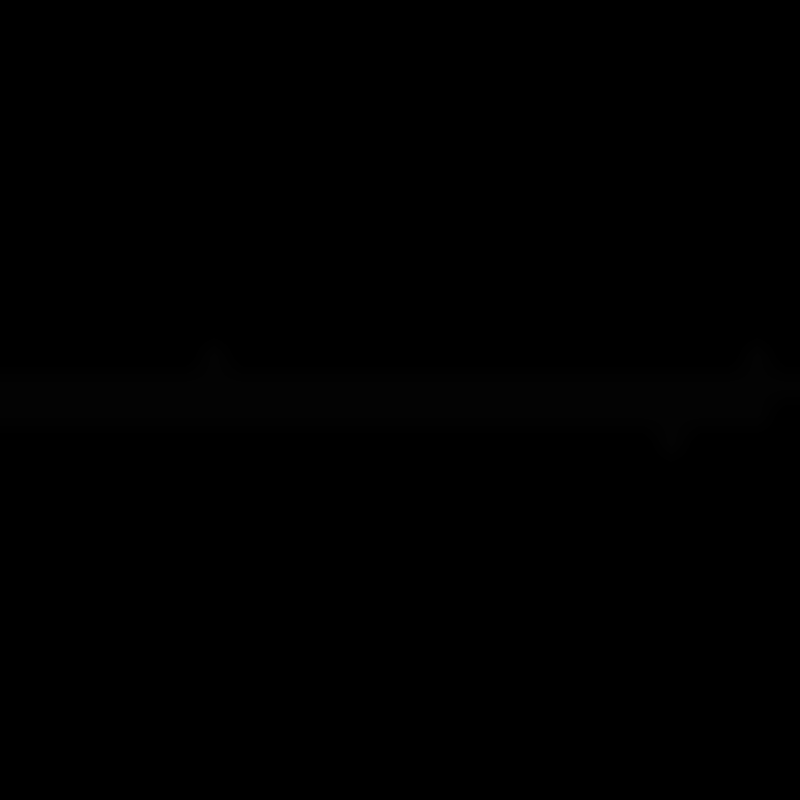

Target label:  11
Predicted label:  11


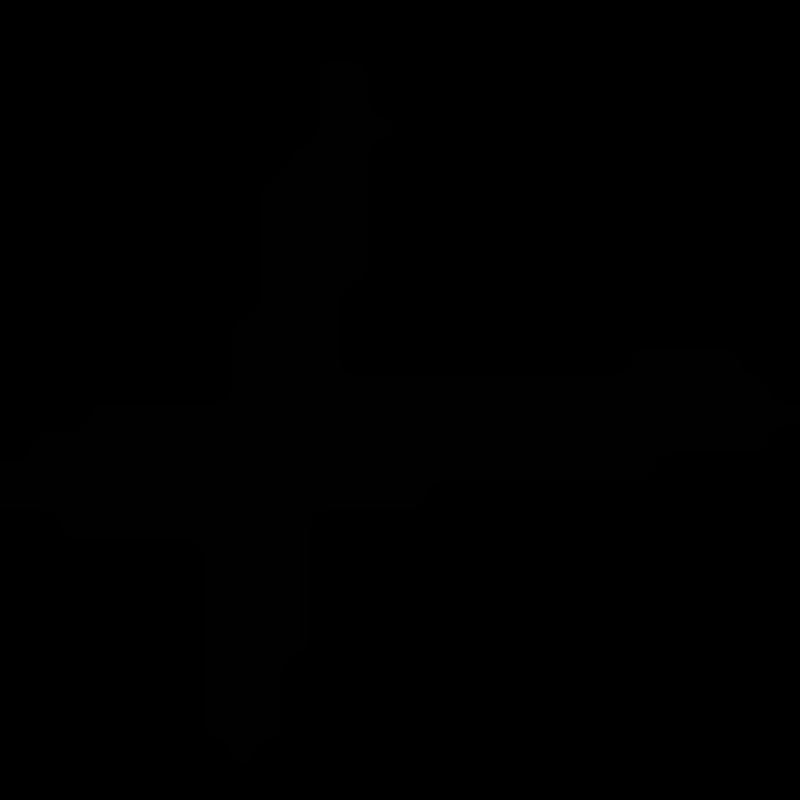

Target label:  10
Predicted label:  10


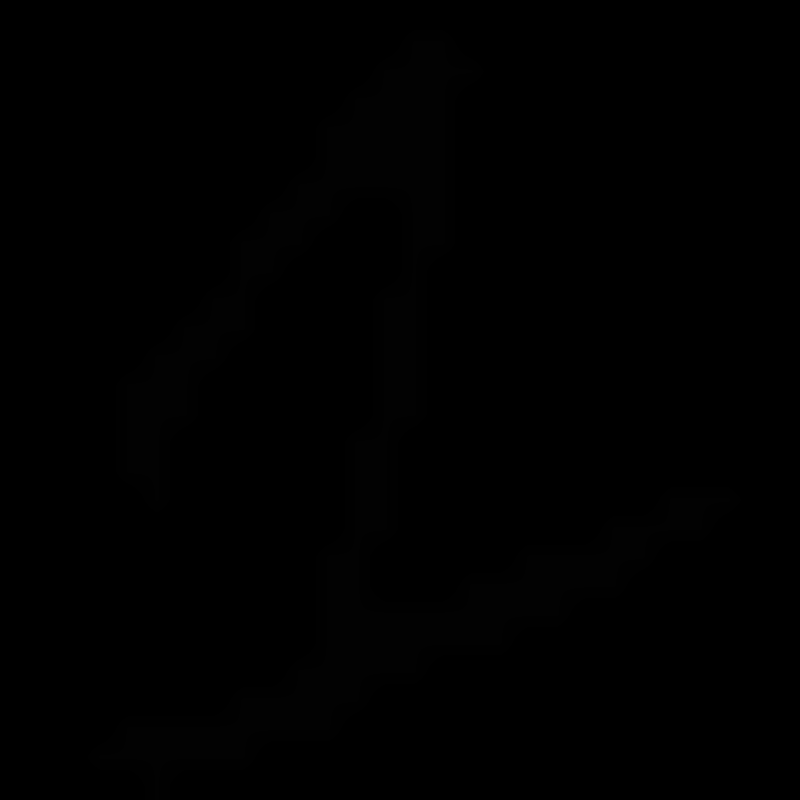

Target label:  1
Predicted label:  1


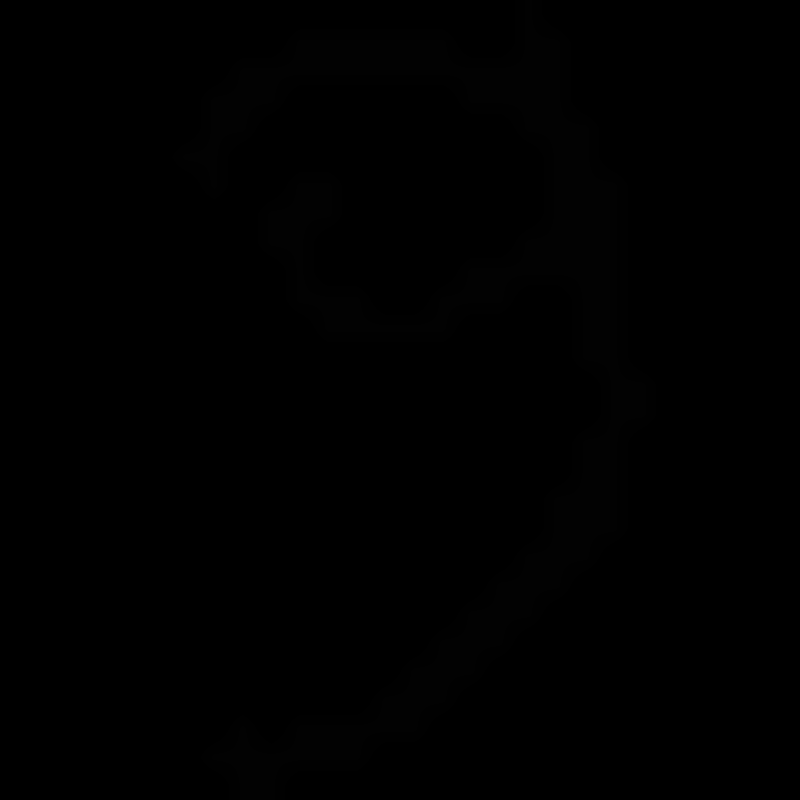

Target label:  9
Predicted label:  9


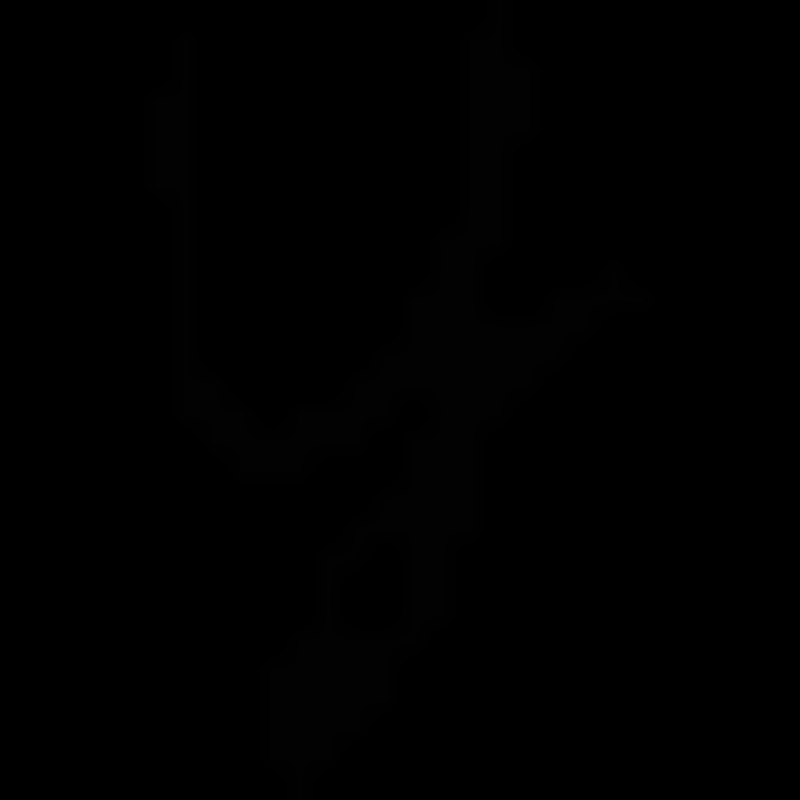

Target label:  16
Predicted label:  16


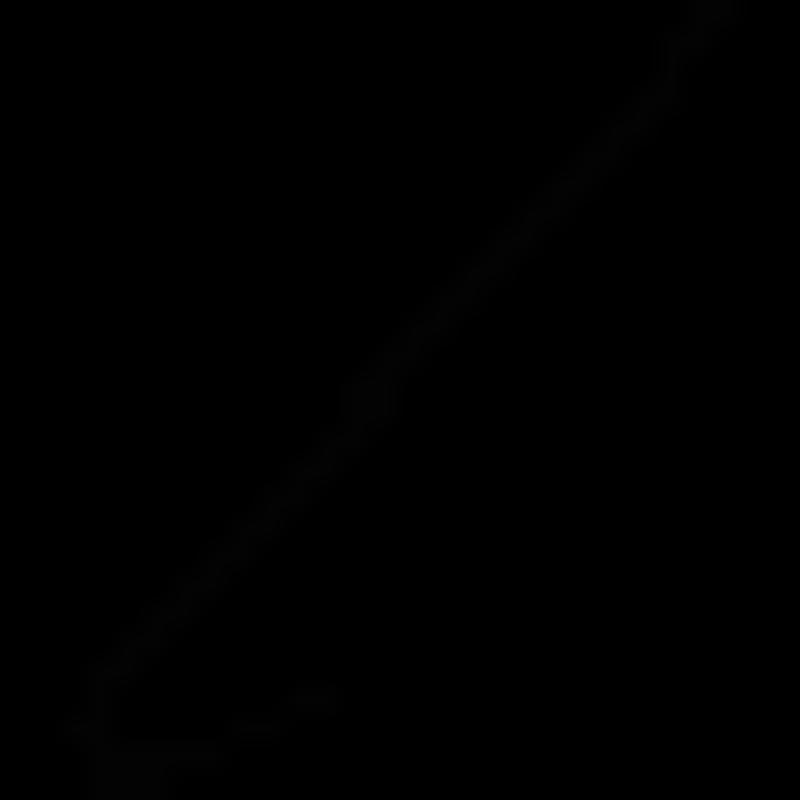

Target label:  12
Predicted label:  12


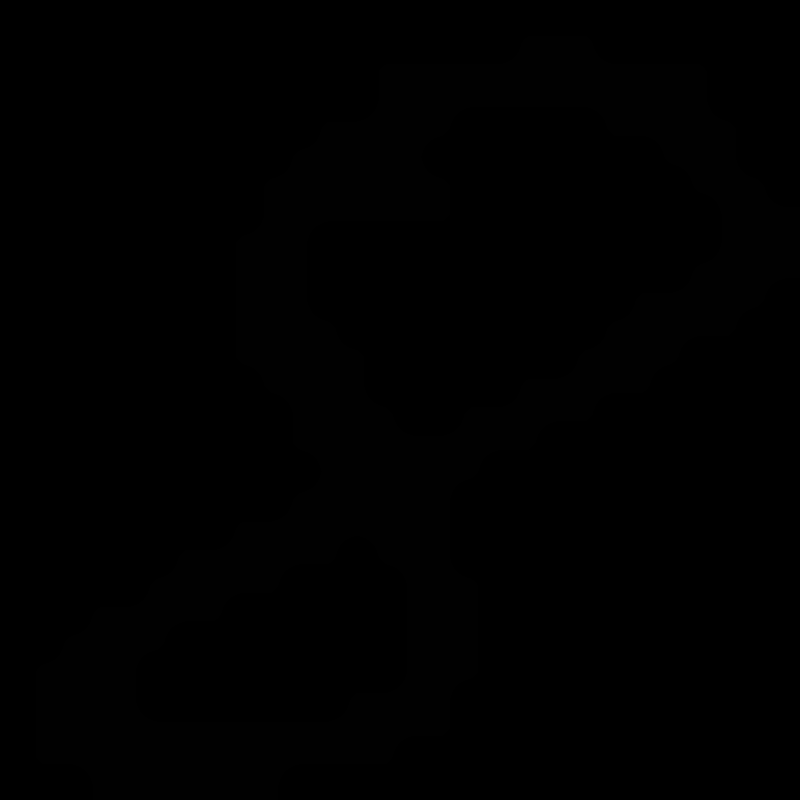

Target label:  8
Predicted label:  8


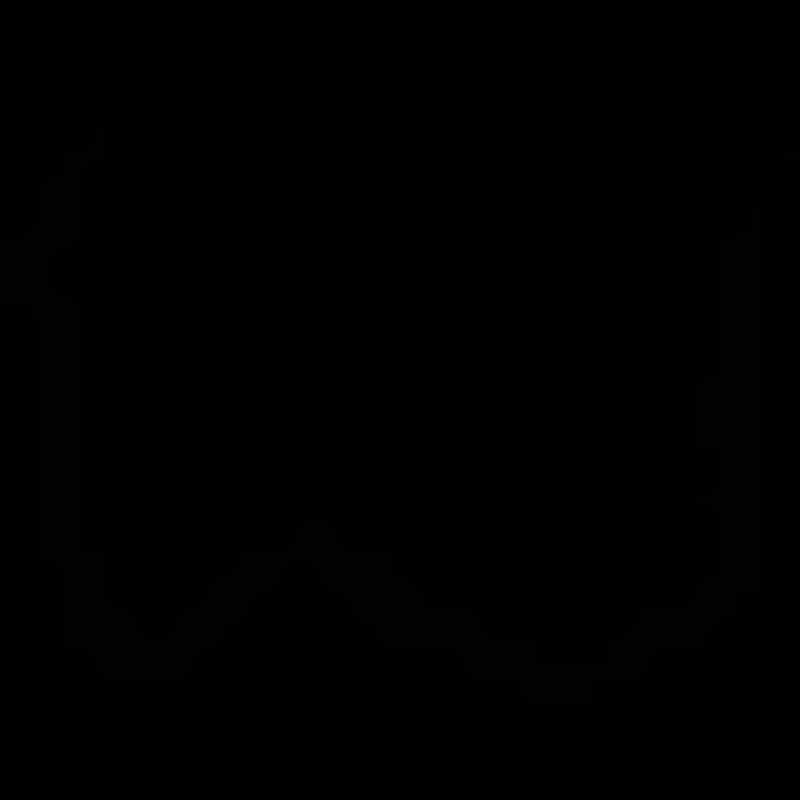

Target label:  14
Predicted label:  14


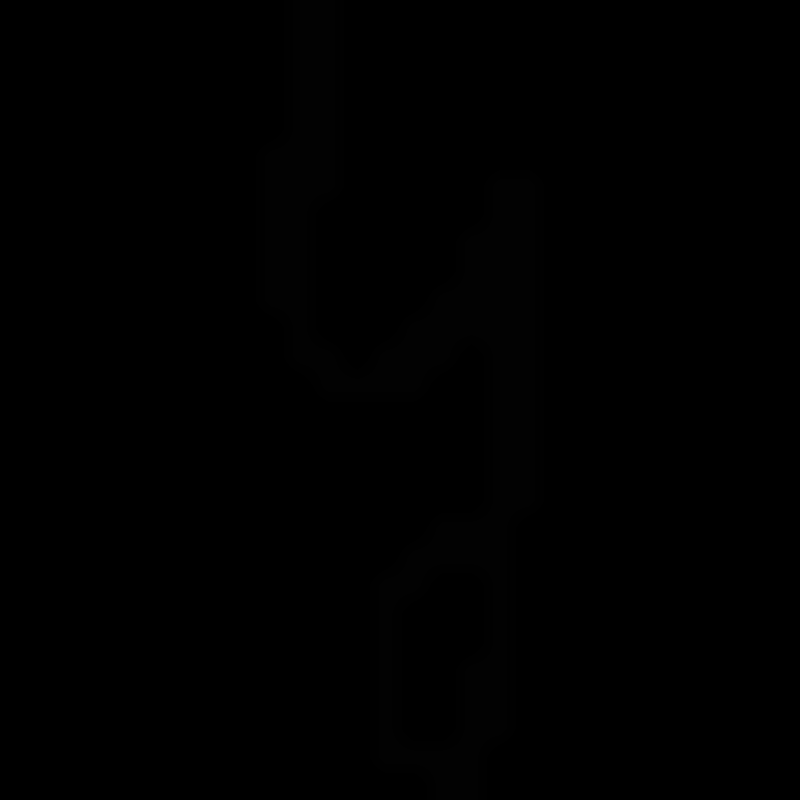

Target label:  16
Predicted label:  16


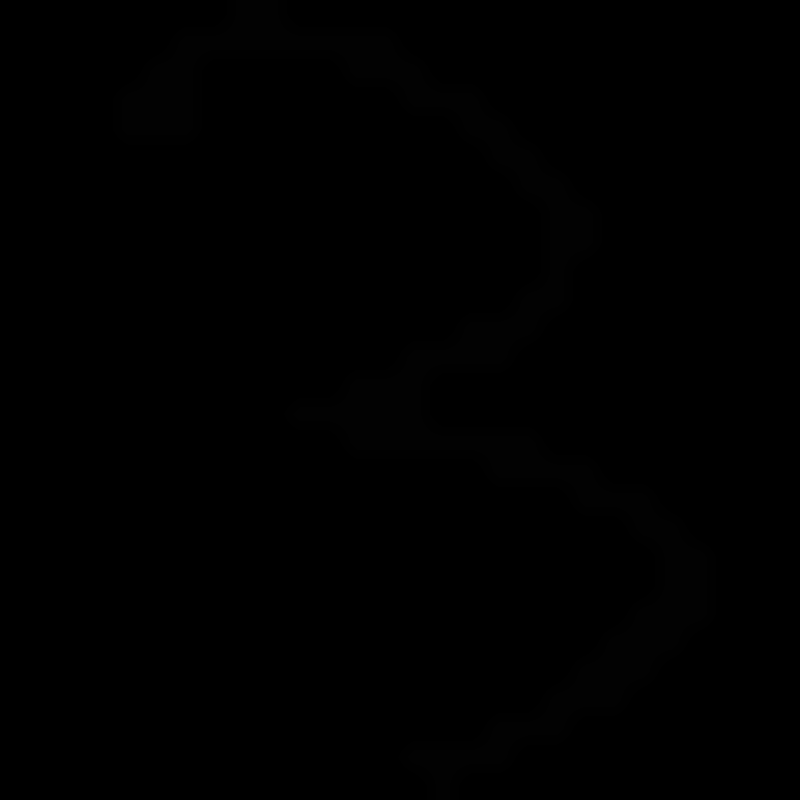

Target label:  3
Predicted label:  3


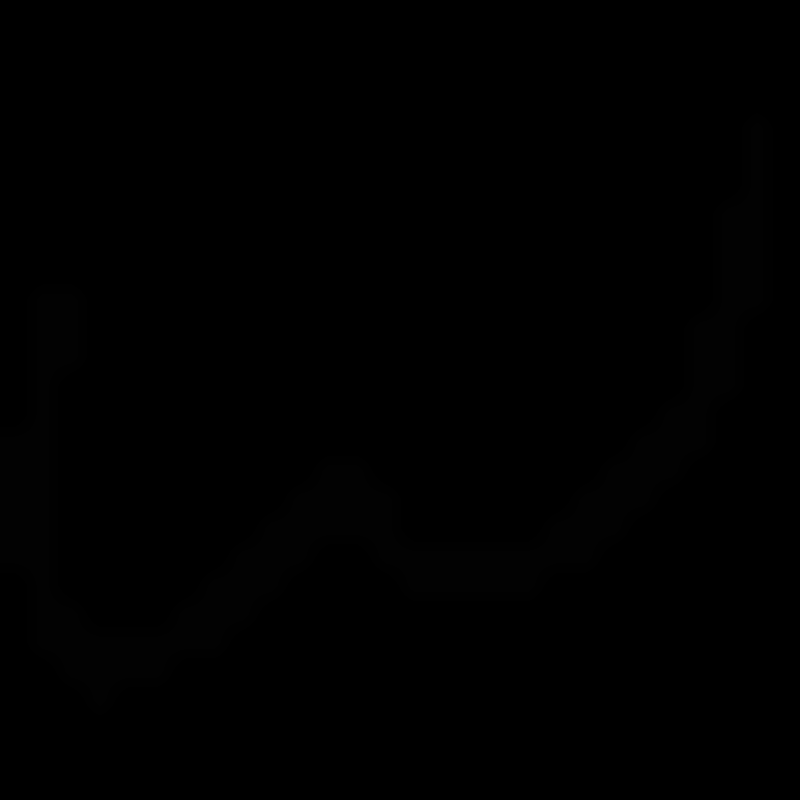

Target label:  14
Predicted label:  14


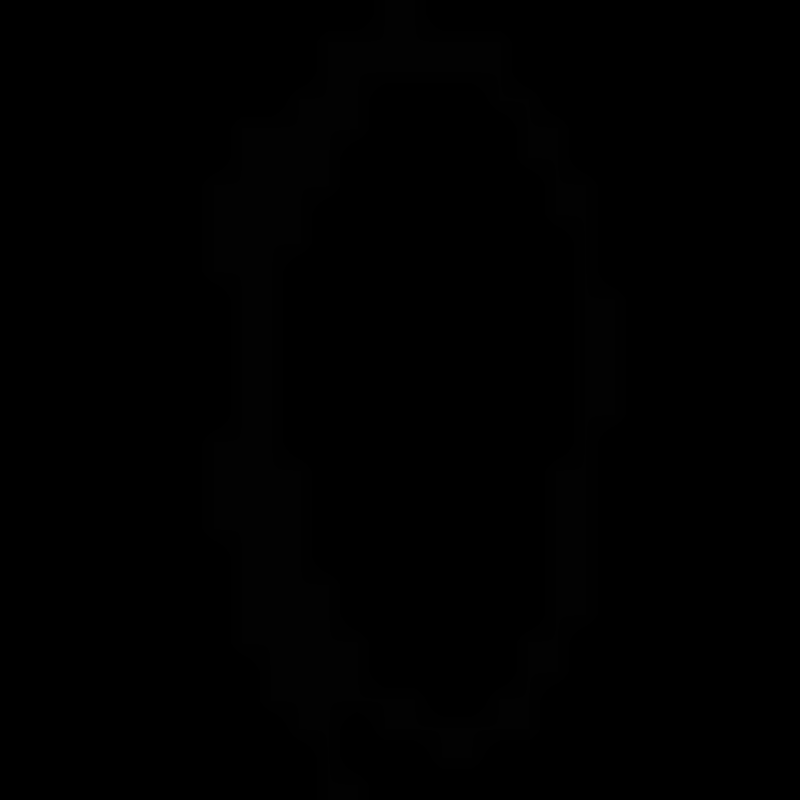

Target label:  0
Predicted label:  0


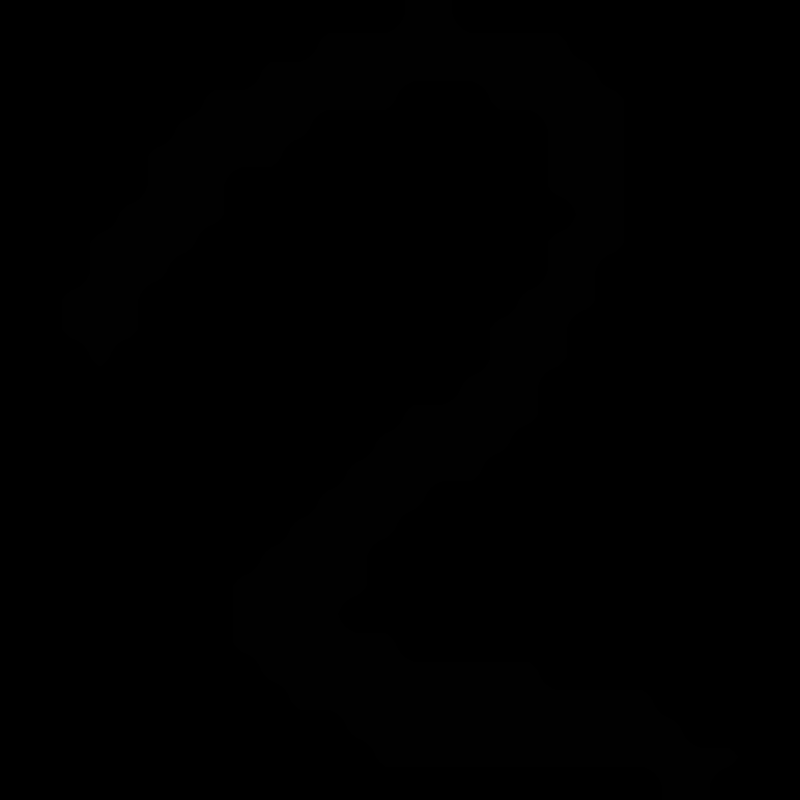

Target label:  2
Predicted label:  2


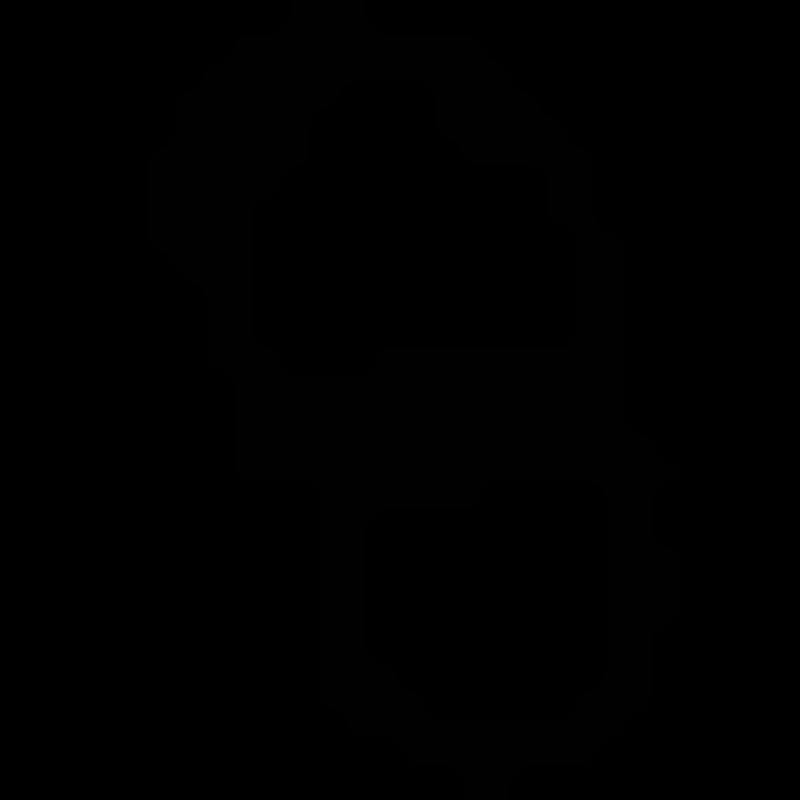

Target label:  8
Predicted label:  8


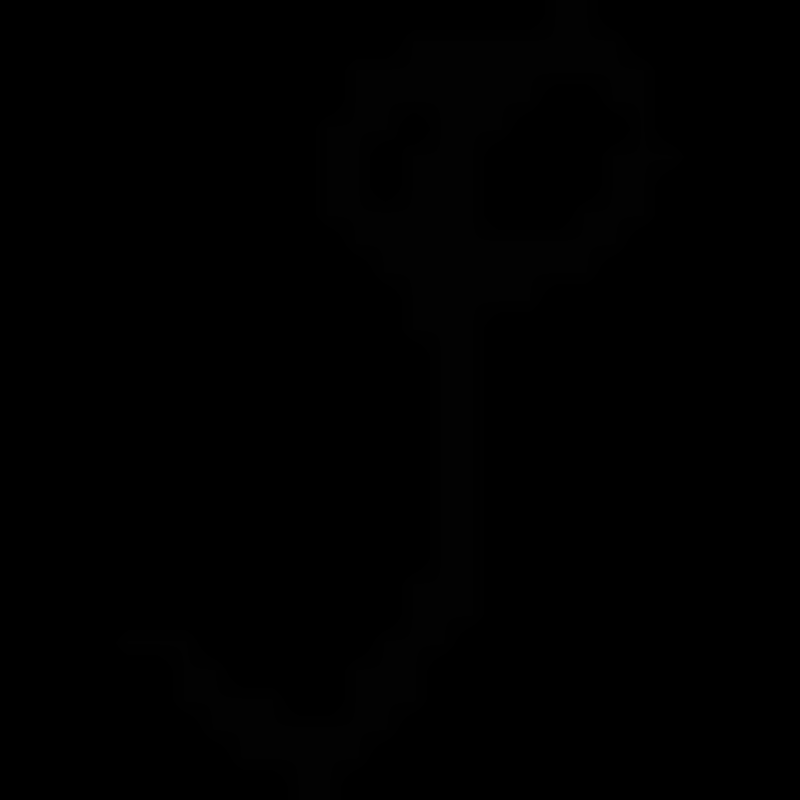

Target label:  9
Predicted label:  16


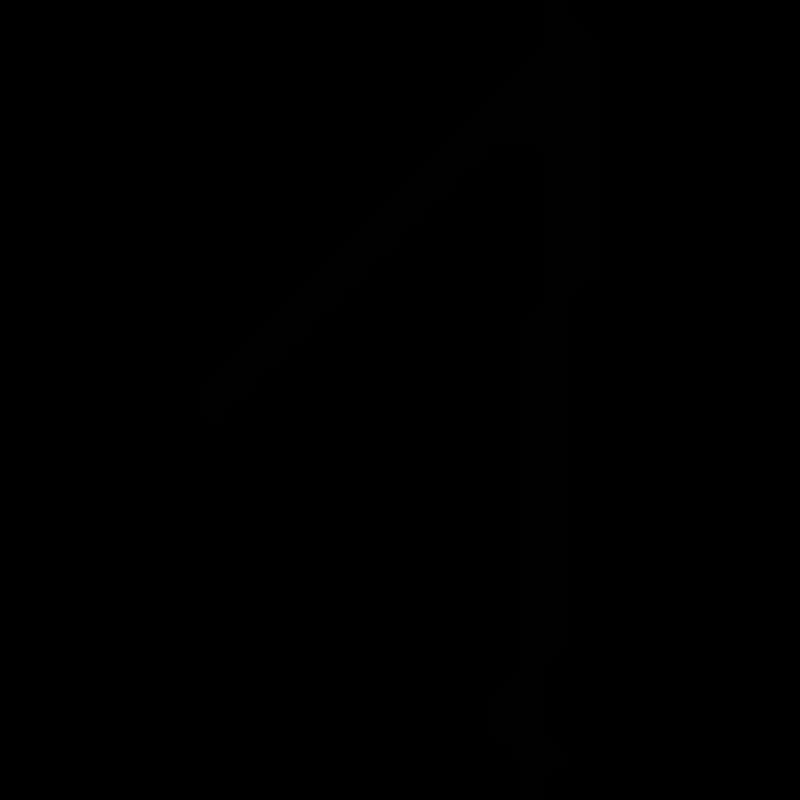

Target label:  1
Predicted label:  1


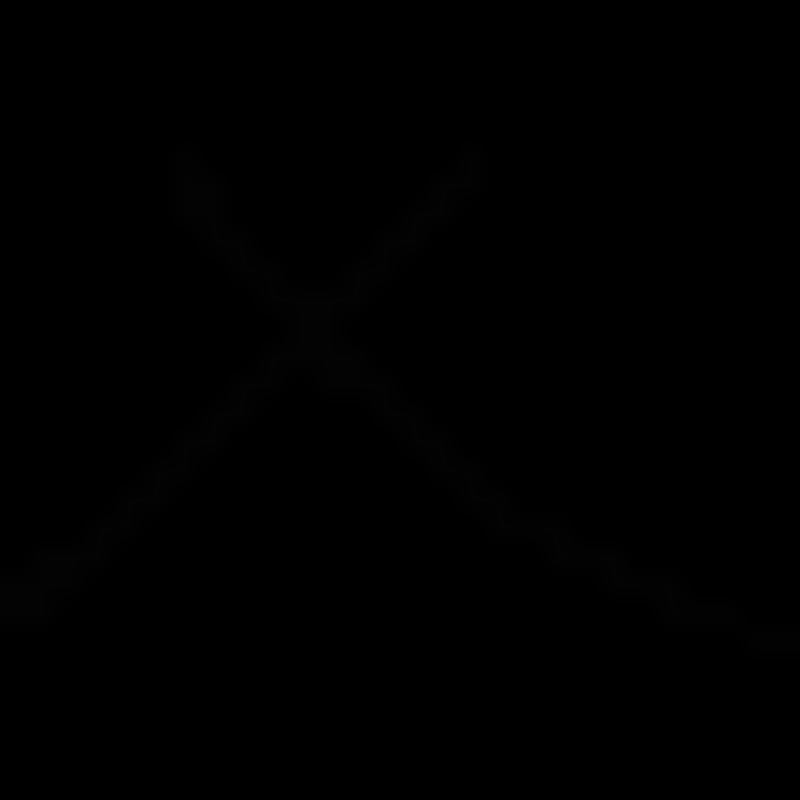

Target label:  15
Predicted label:  15


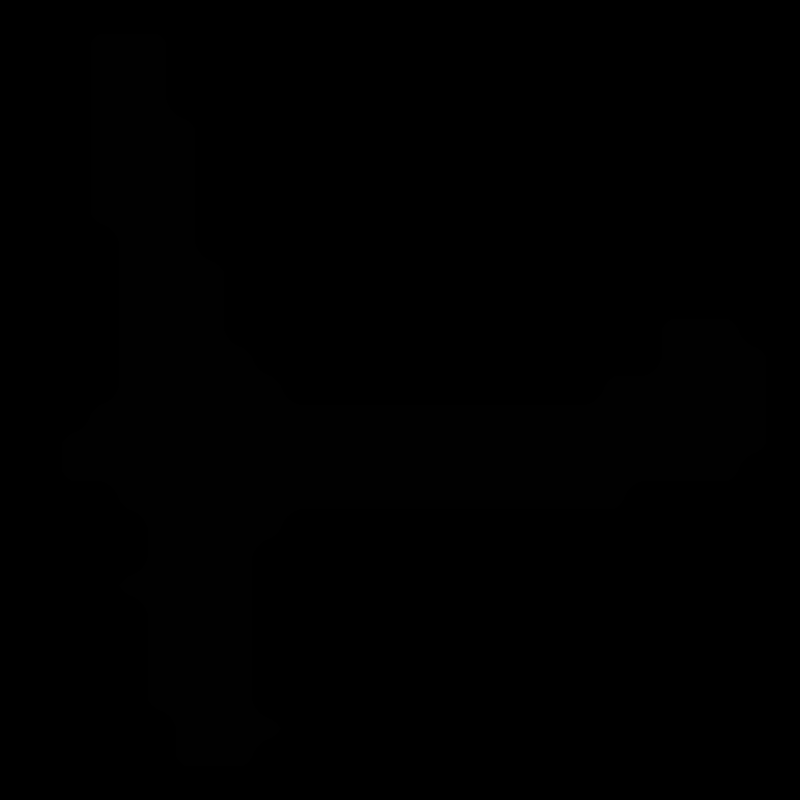

Target label:  10
Predicted label:  14


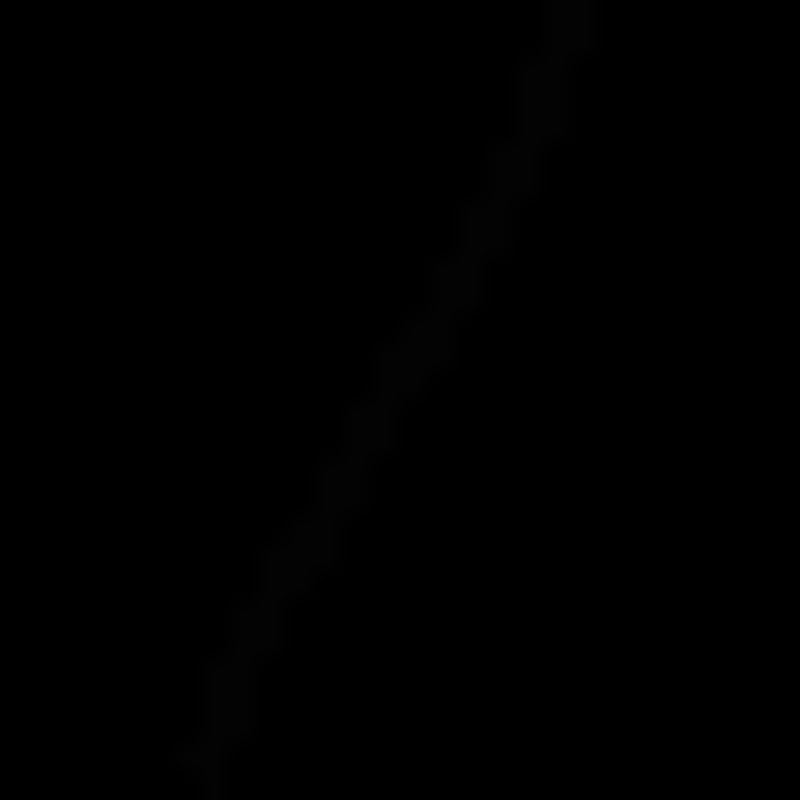

Target label:  12
Predicted label:  12


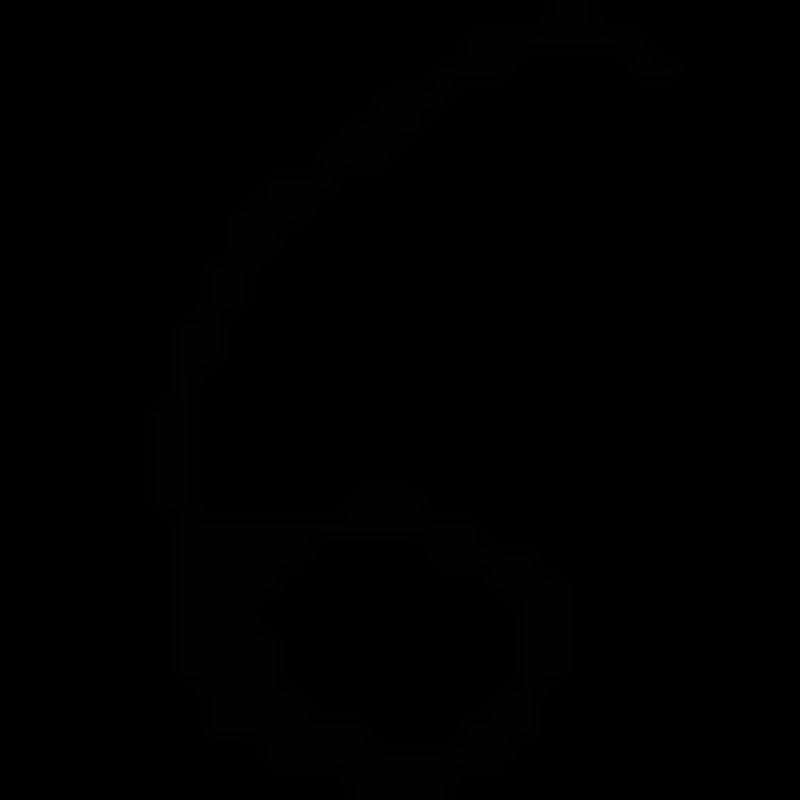

Target label:  6
Predicted label:  6


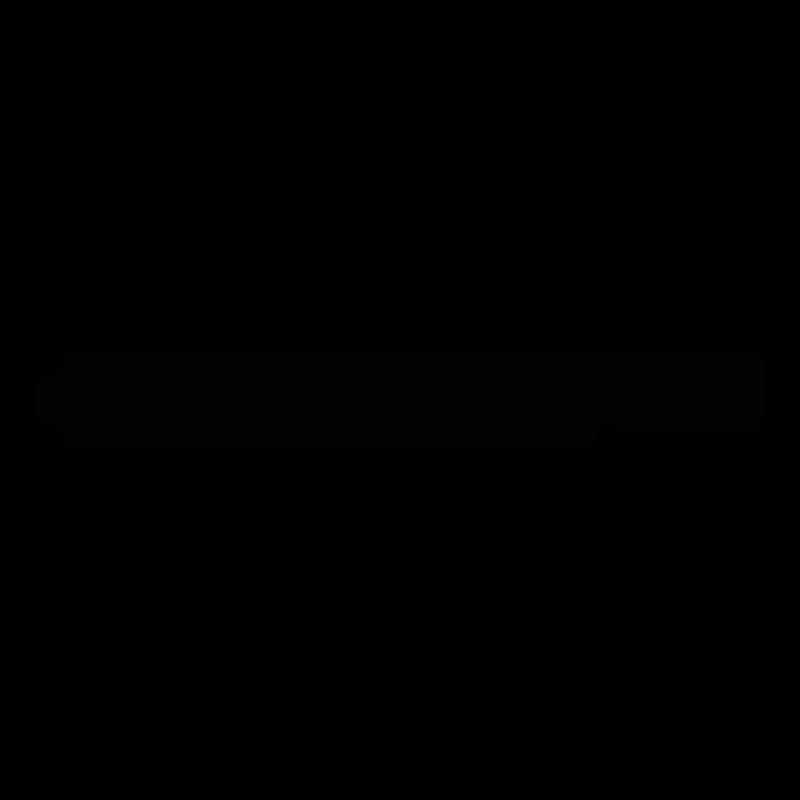

Target label:  11
Predicted label:  11

Test set: Average loss: 0.3336, Accuracy: 2487.0/2700 (92%)



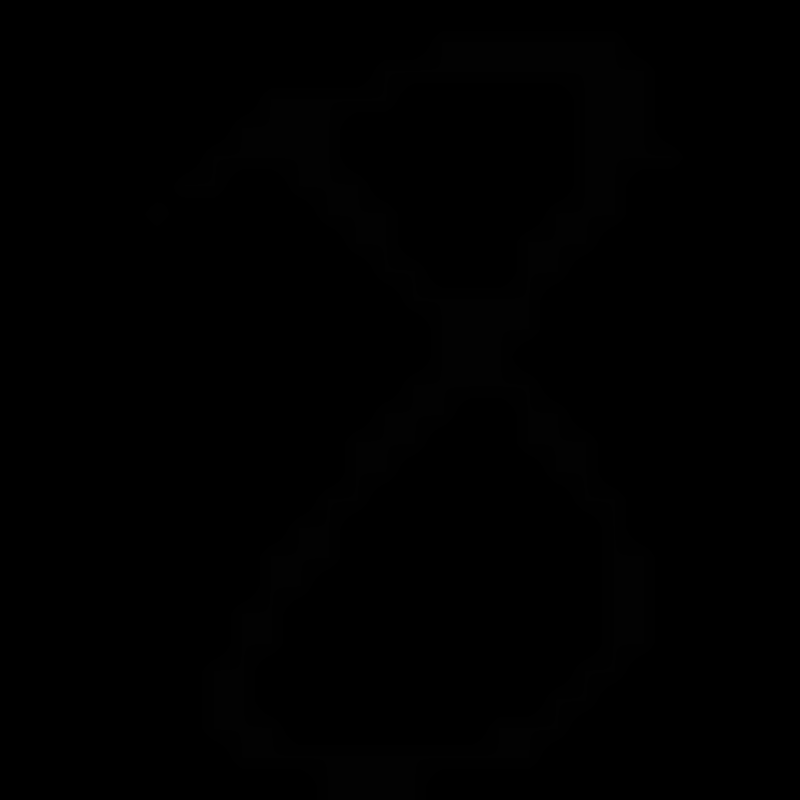

Target label:  8
Predicted label:  8


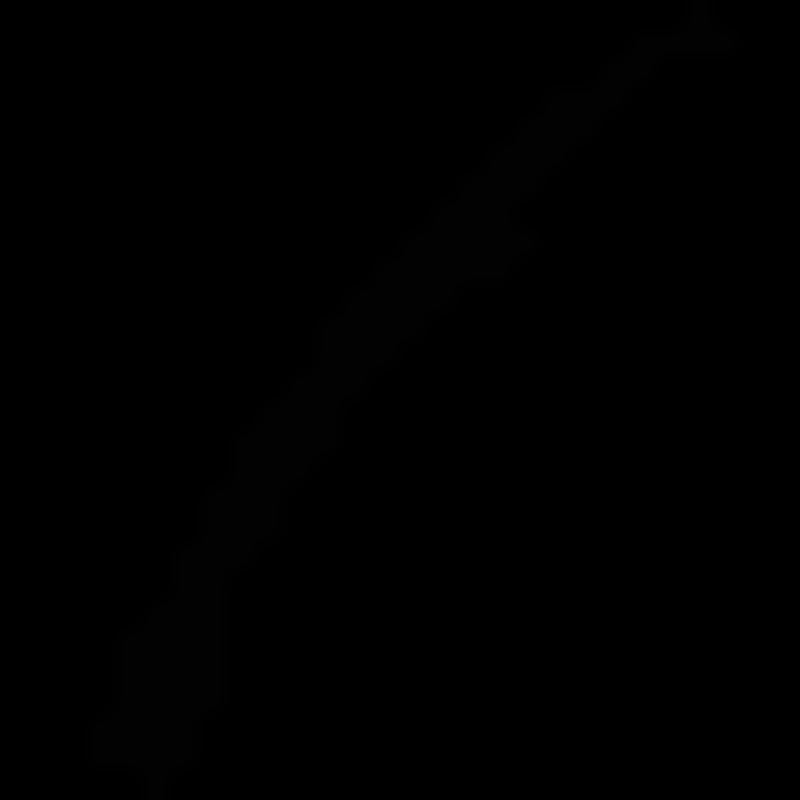

Target label:  12
Predicted label:  12


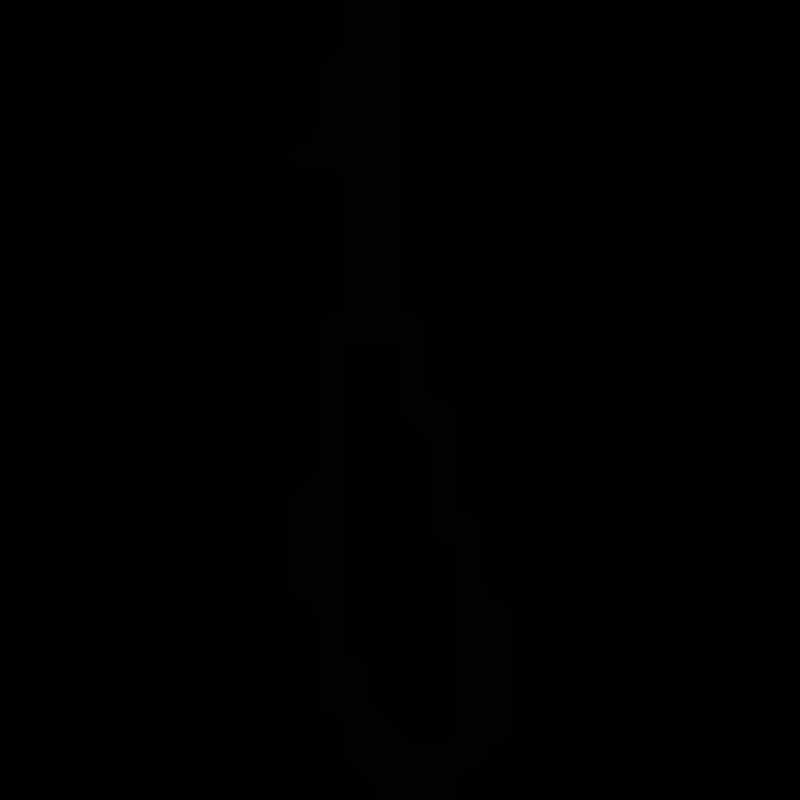

Target label:  8
Predicted label:  8


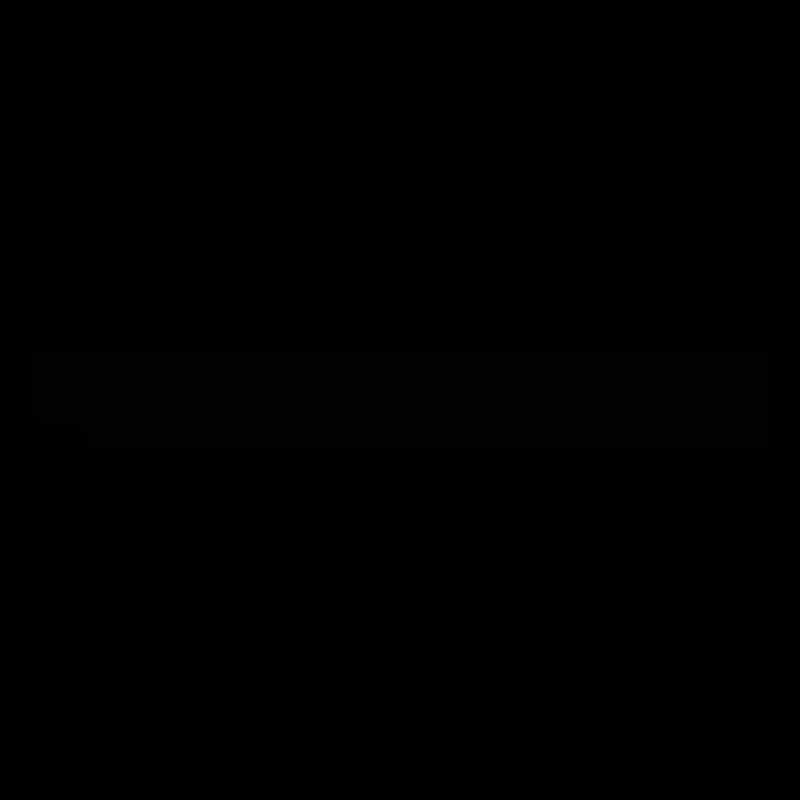

Target label:  11
Predicted label:  11


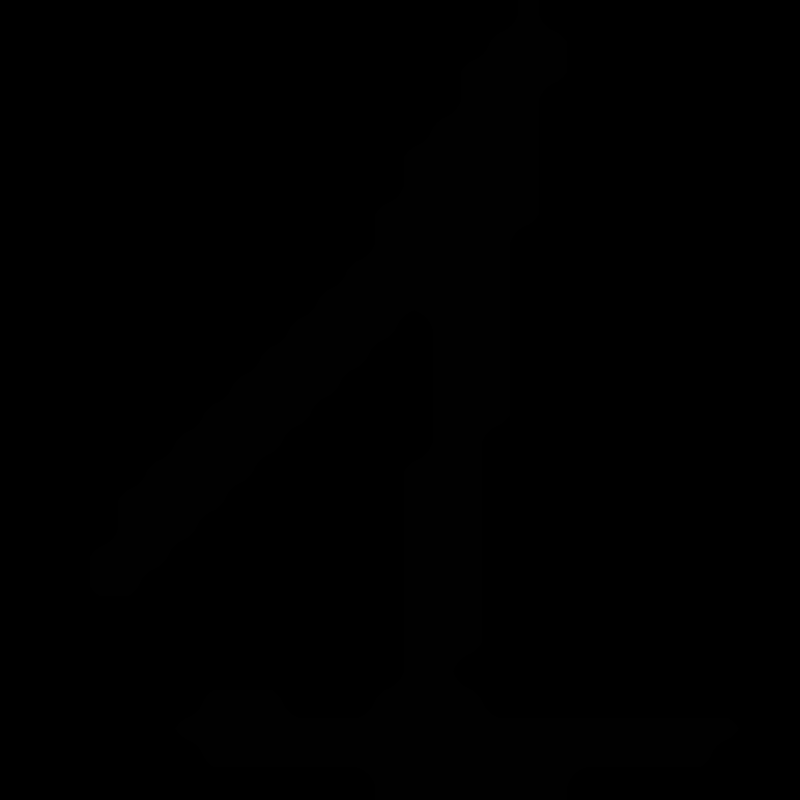

Target label:  1
Predicted label:  1


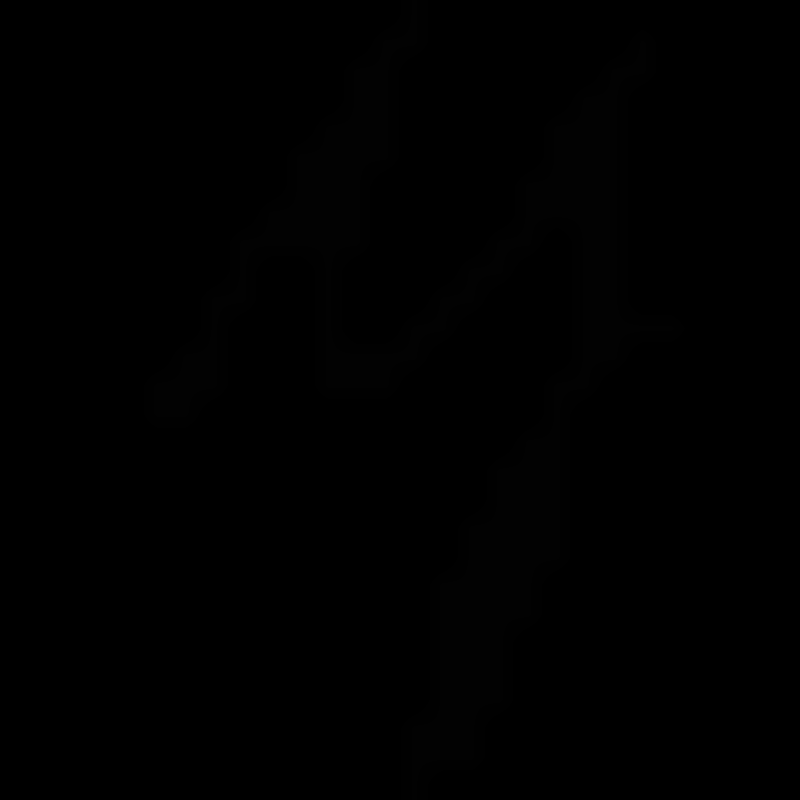

Target label:  16
Predicted label:  16


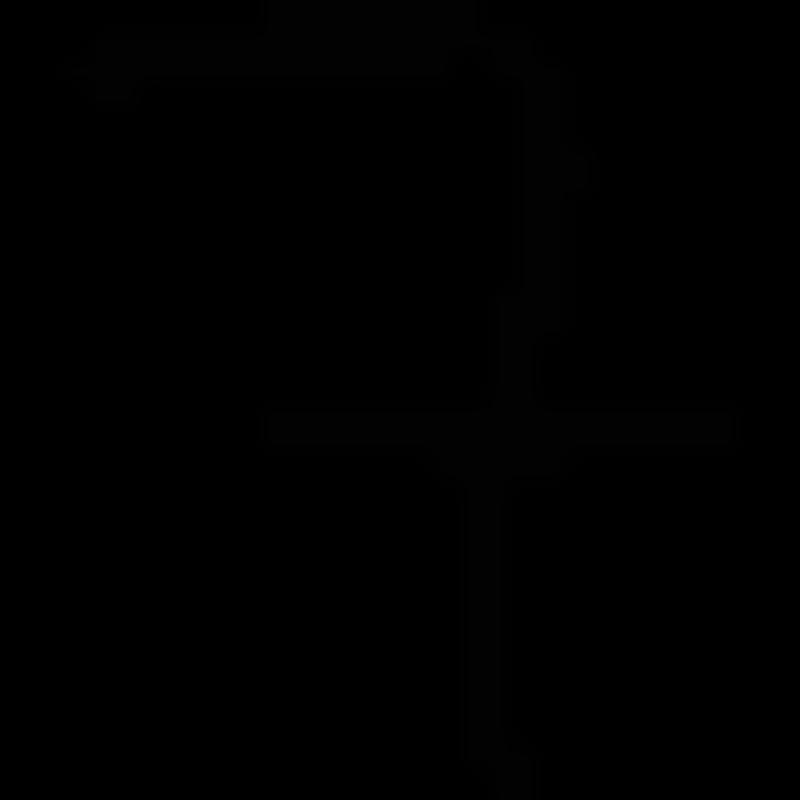

Target label:  7
Predicted label:  7


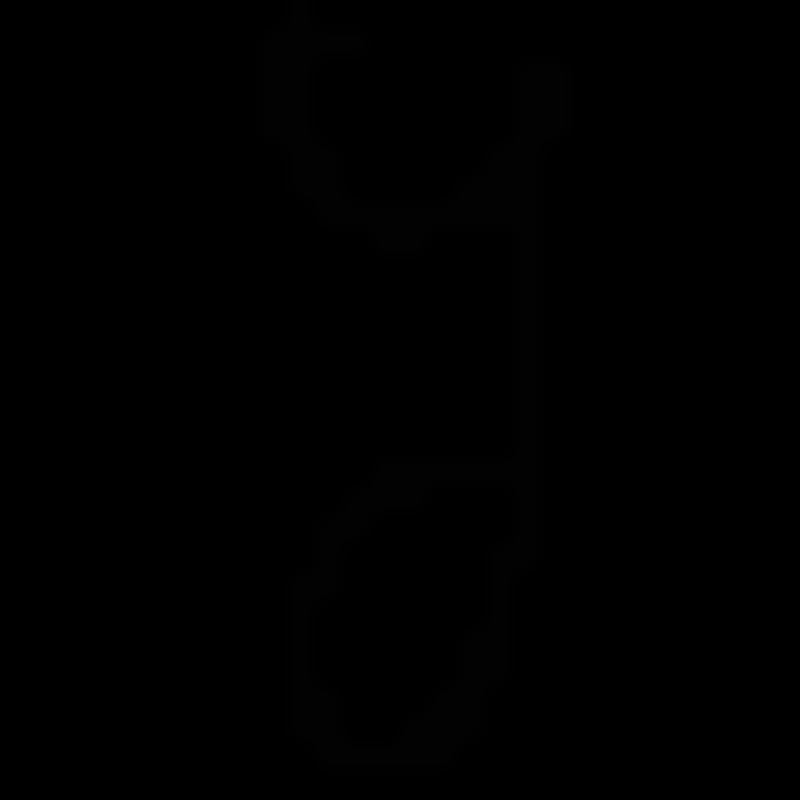

Target label:  16
Predicted label:  16


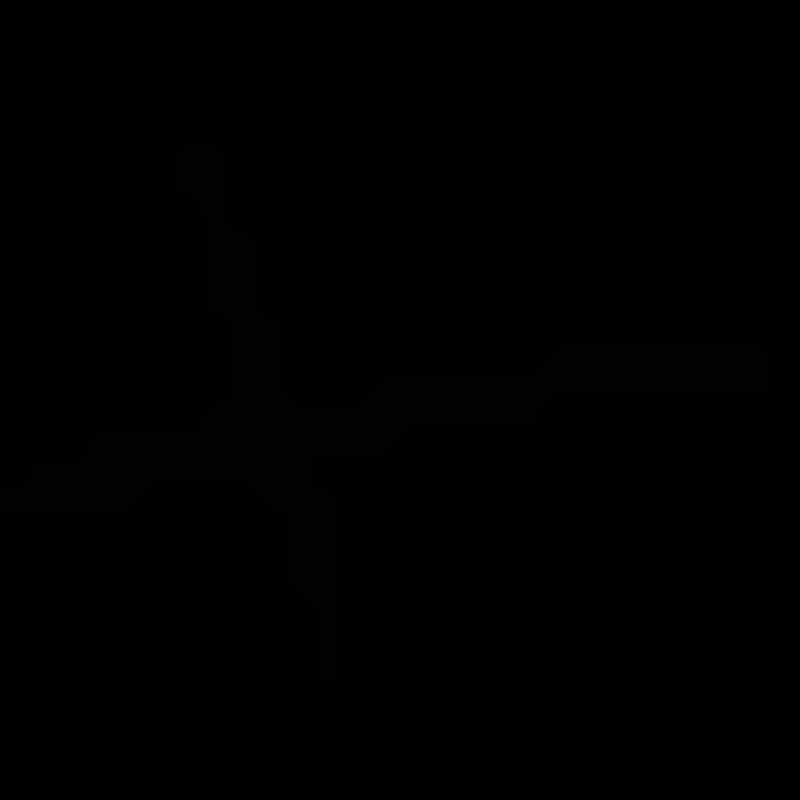

Target label:  10
Predicted label:  10


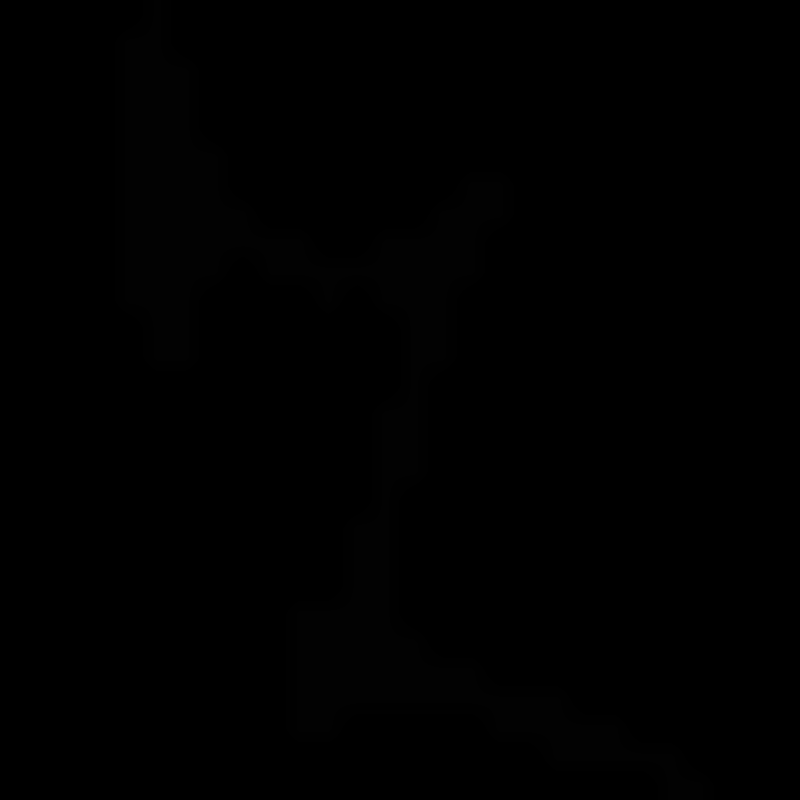

Target label:  17
Predicted label:  17


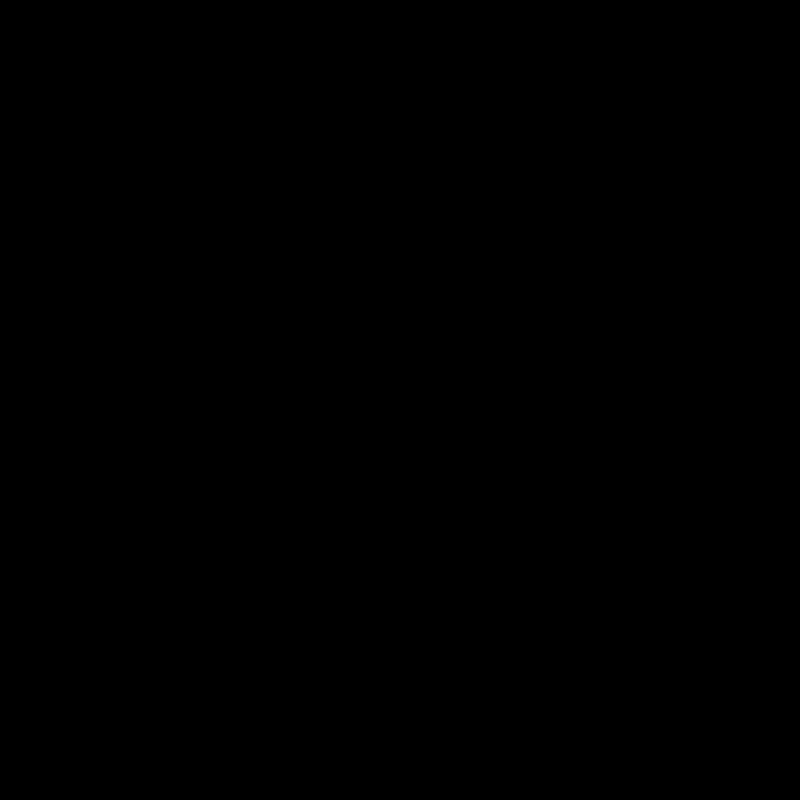

Target label:  10
Predicted label:  10


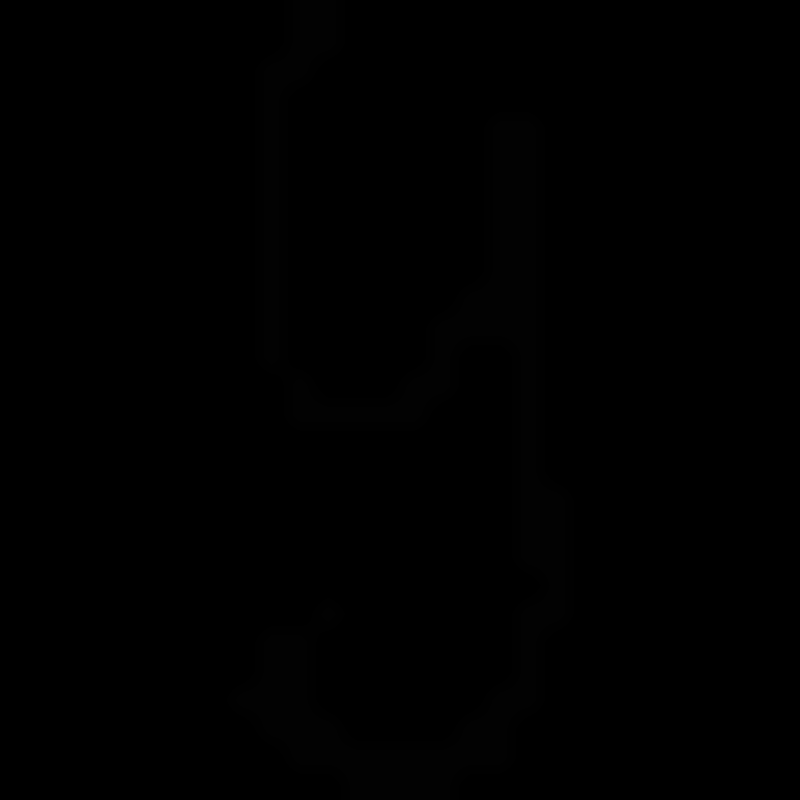

Target label:  16
Predicted label:  16


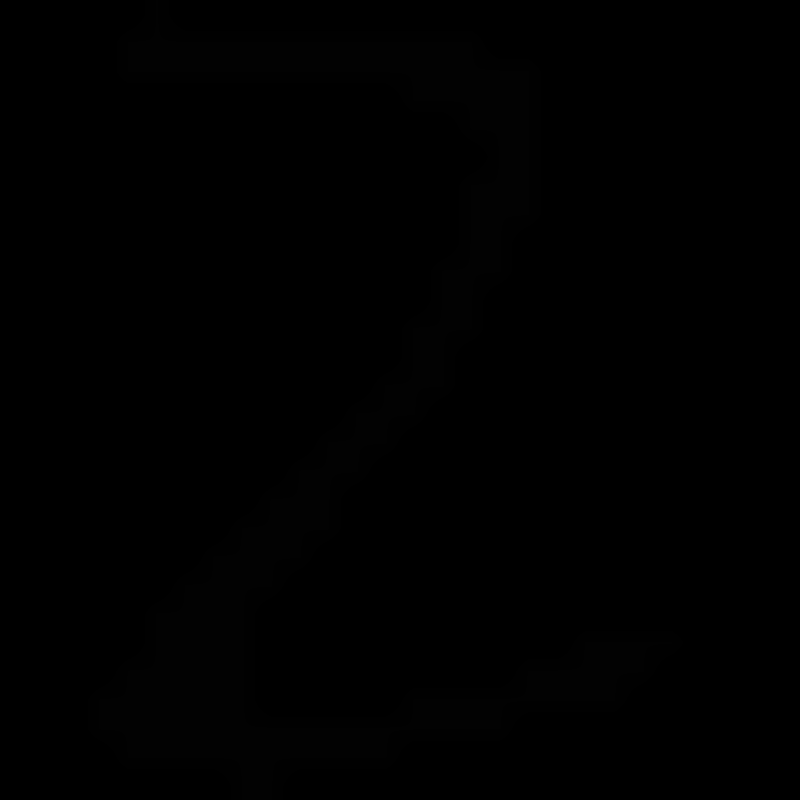

Target label:  17
Predicted label:  17


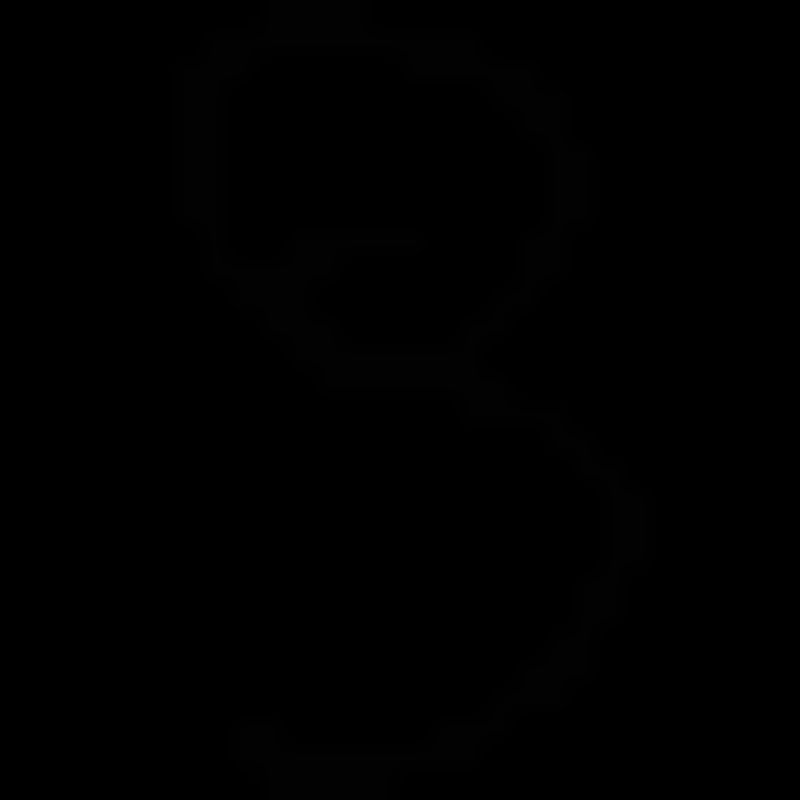

Target label:  9
Predicted label:  9


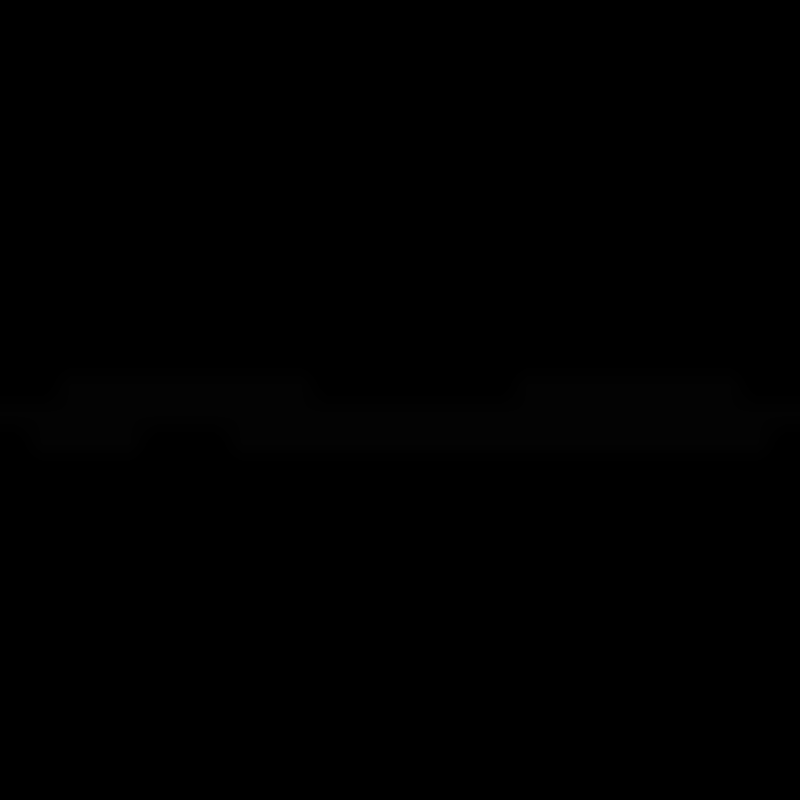

Target label:  11
Predicted label:  11


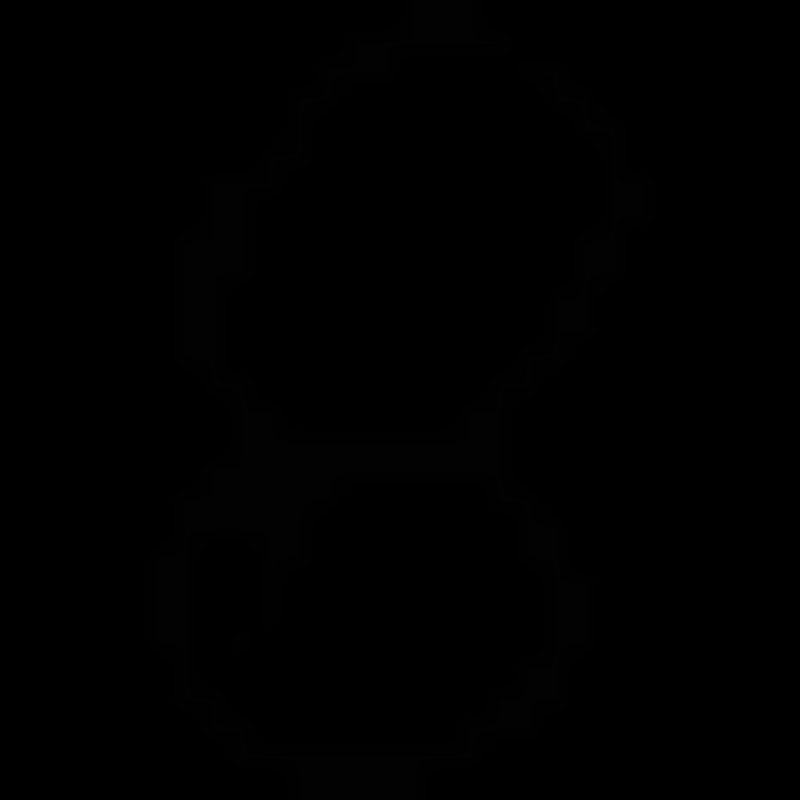

Target label:  8
Predicted label:  8


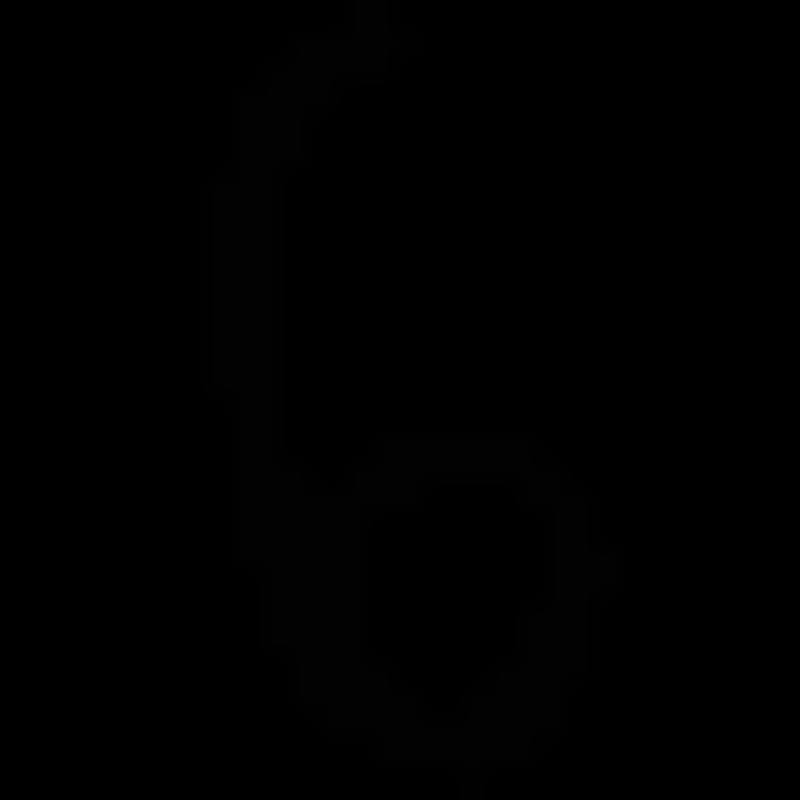

Target label:  6
Predicted label:  6


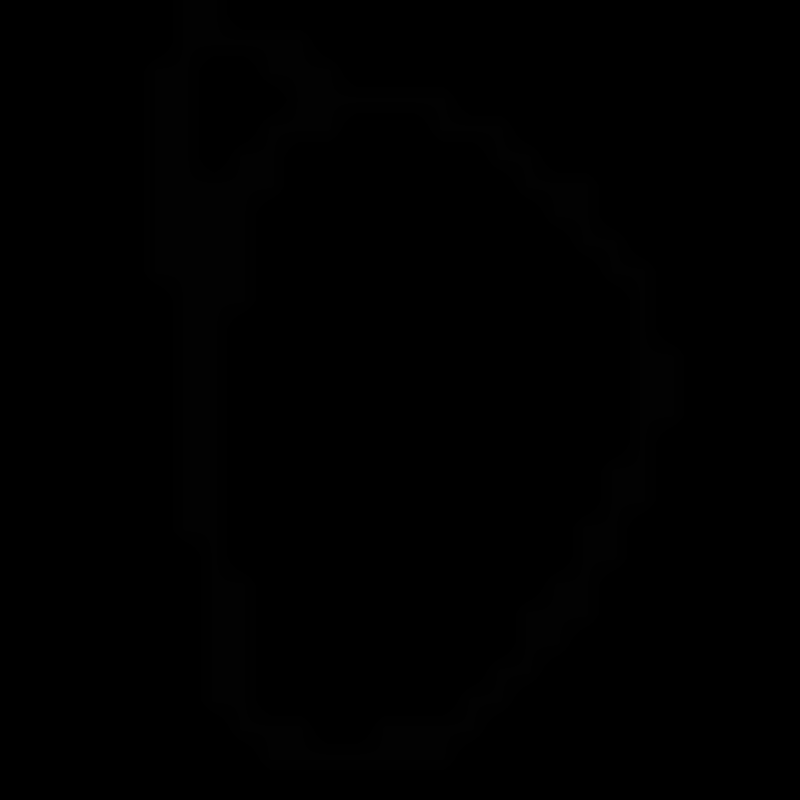

Target label:  0
Predicted label:  0


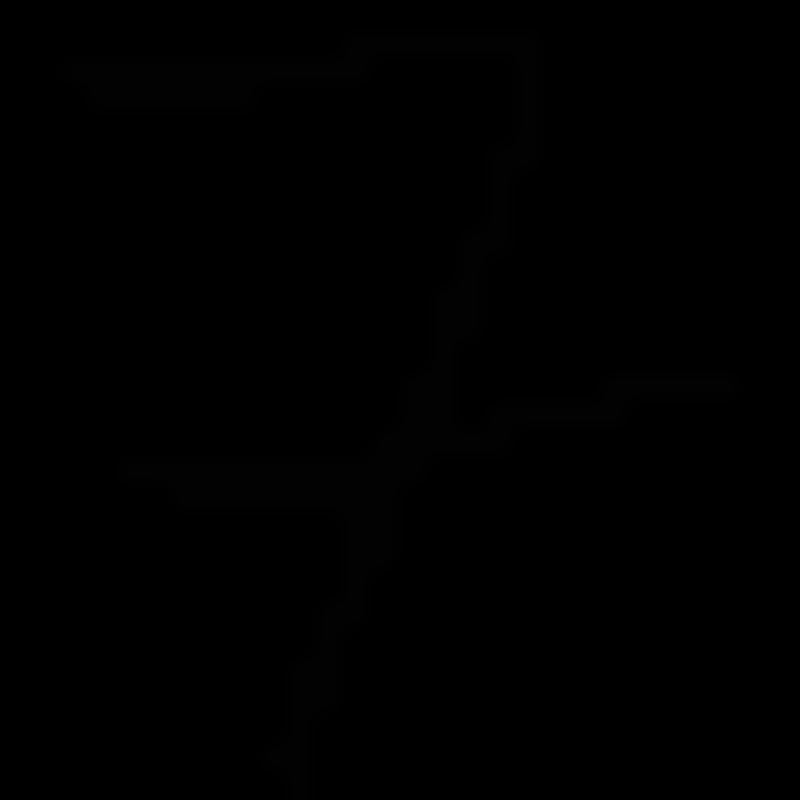

Target label:  7
Predicted label:  7


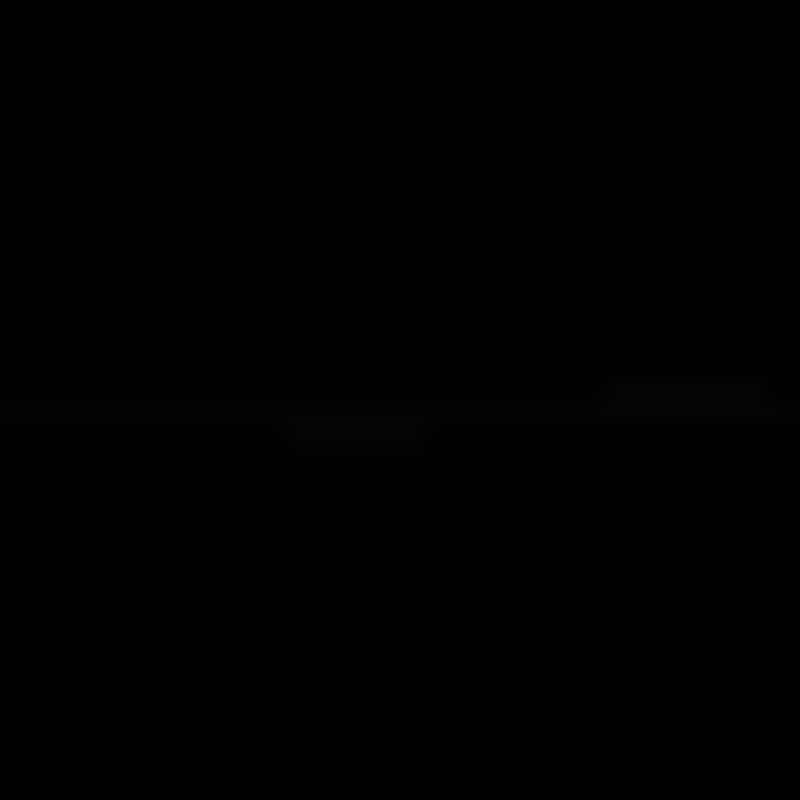

Target label:  11
Predicted label:  11


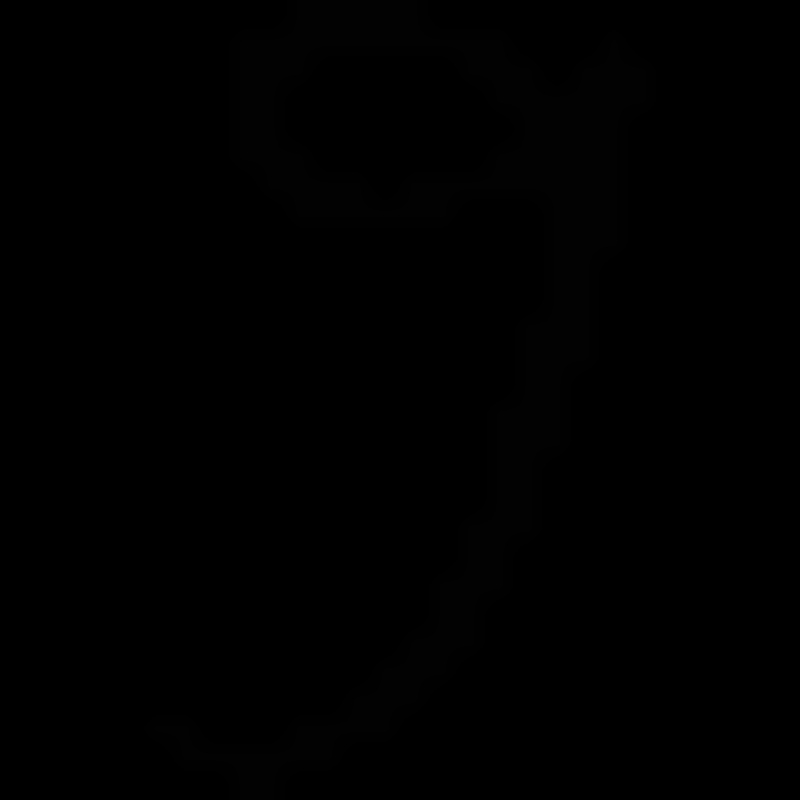

Target label:  9
Predicted label:  9


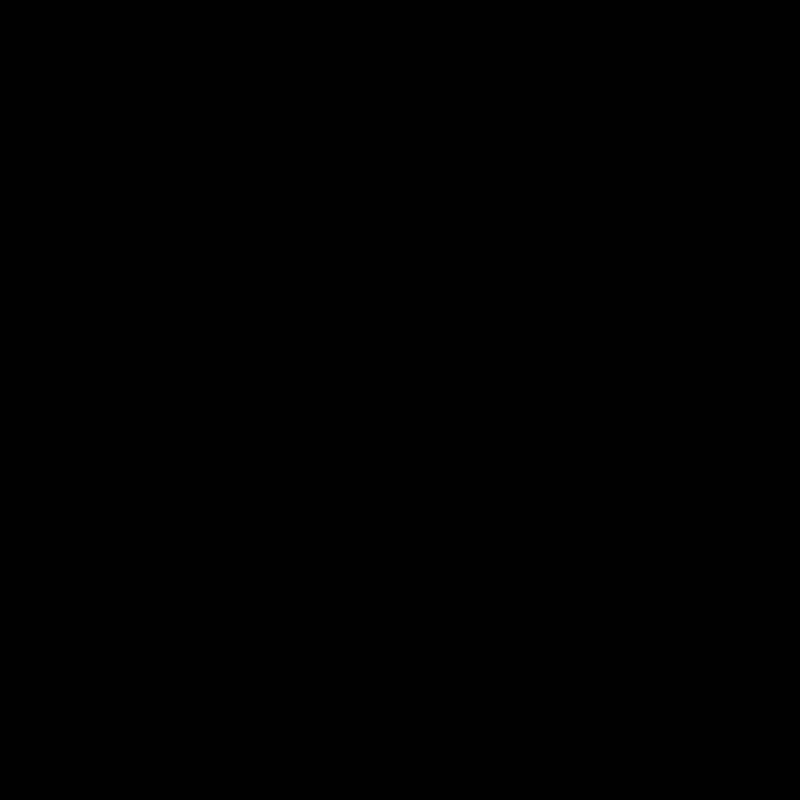

Target label:  13
Predicted label:  13


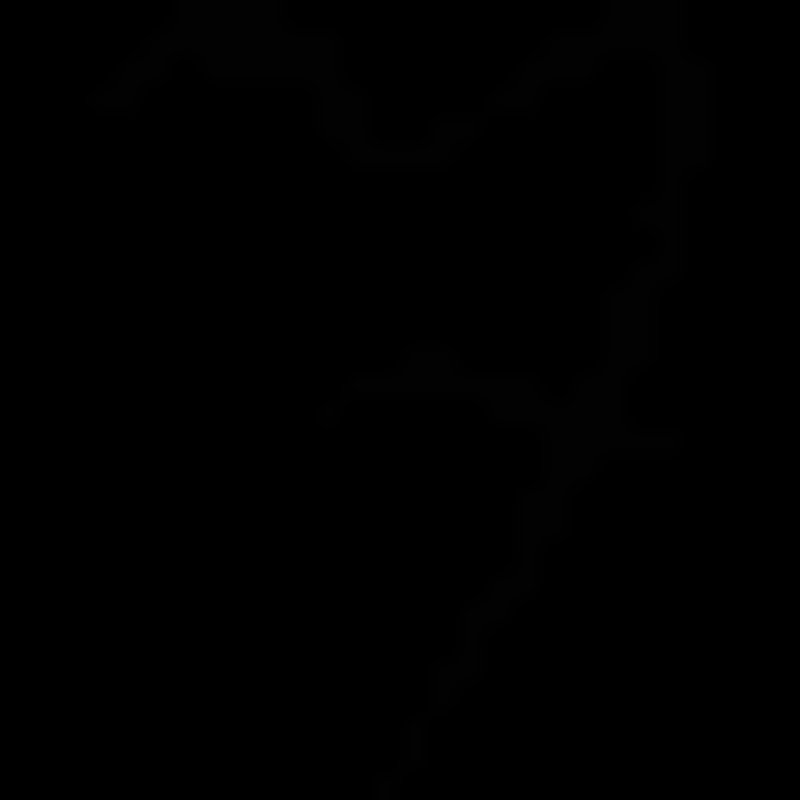

Target label:  7
Predicted label:  3


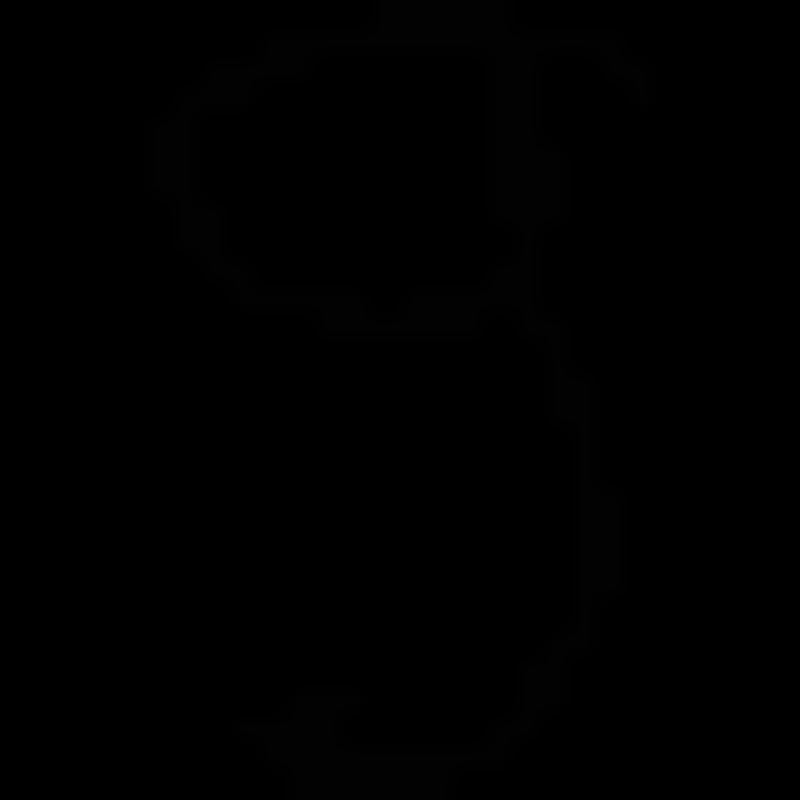

Target label:  9
Predicted label:  9

Test set: Average loss: 0.0606, Accuracy: 2653.0/2700 (98%)



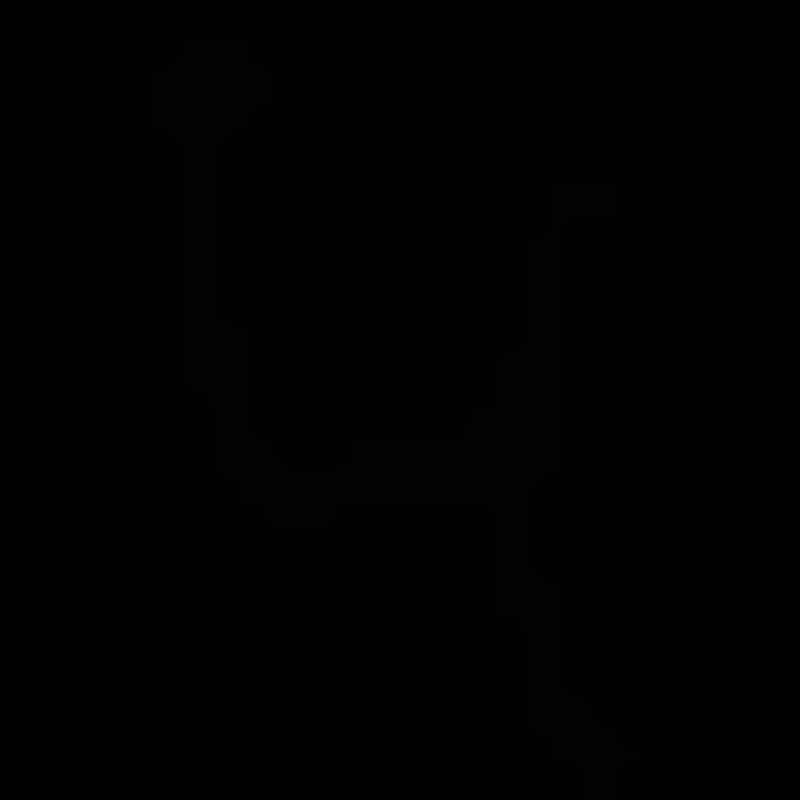

Target label:  4
Predicted label:  4


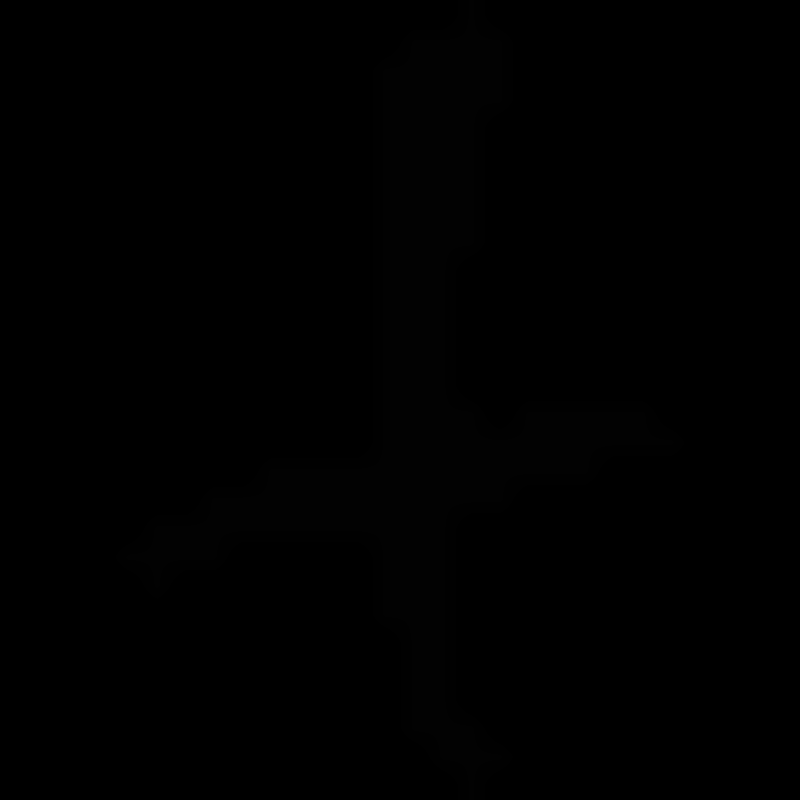

Target label:  10
Predicted label:  7


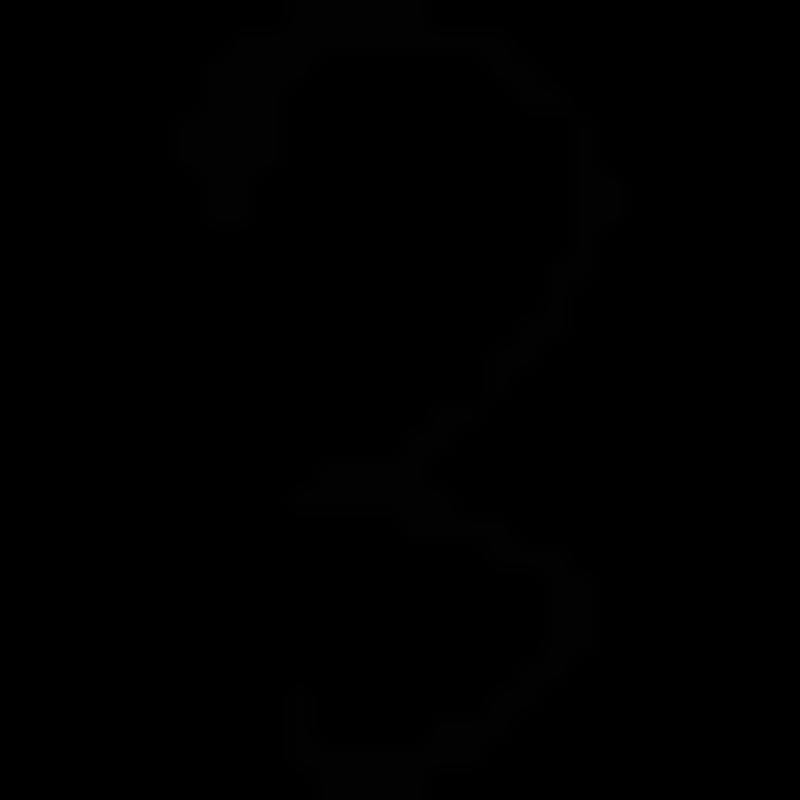

Target label:  3
Predicted label:  8


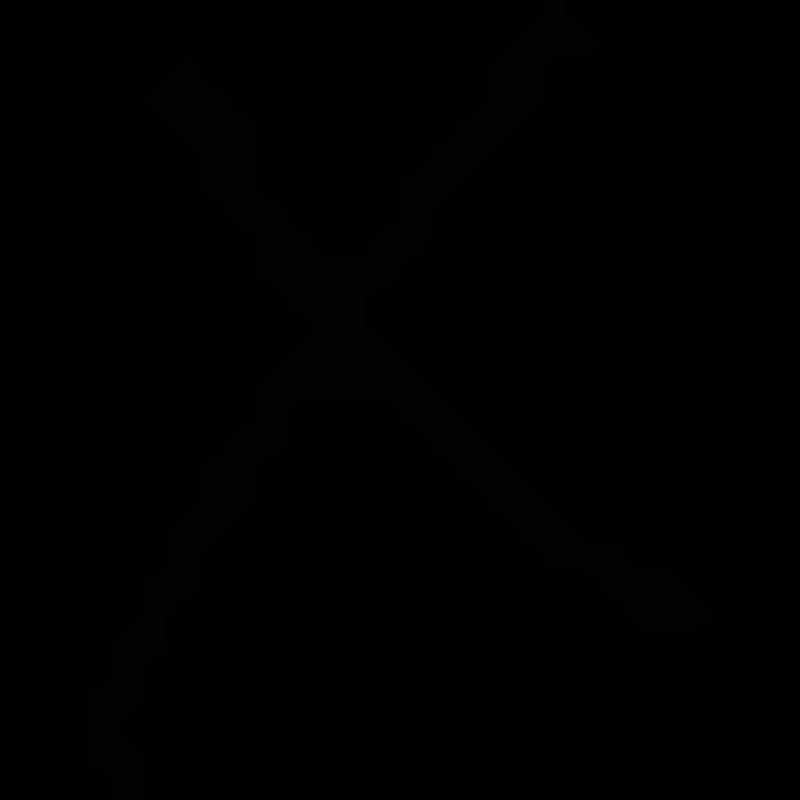

Target label:  15
Predicted label:  15


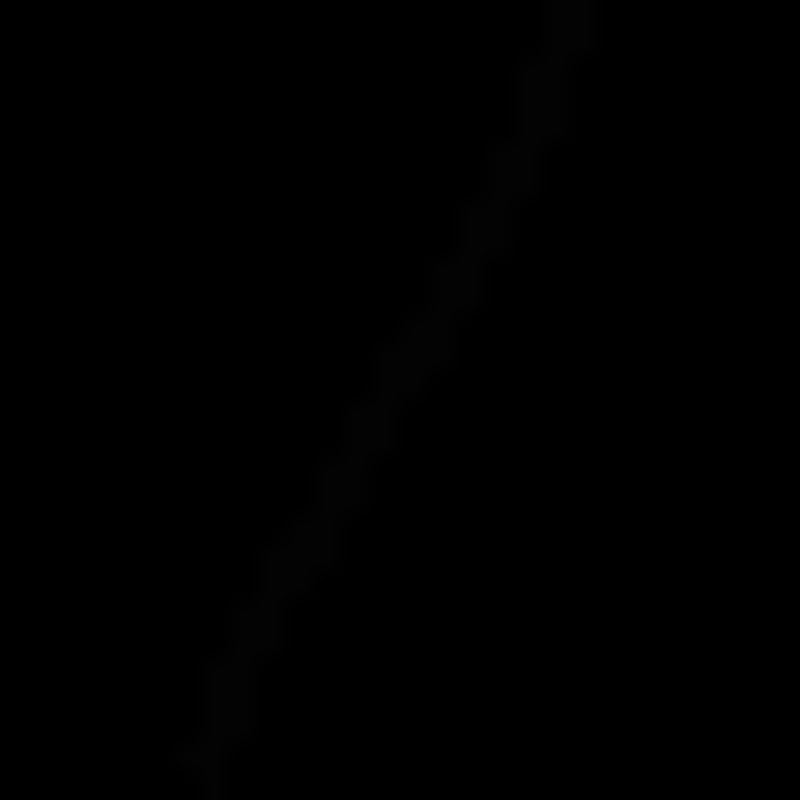

Target label:  12
Predicted label:  12


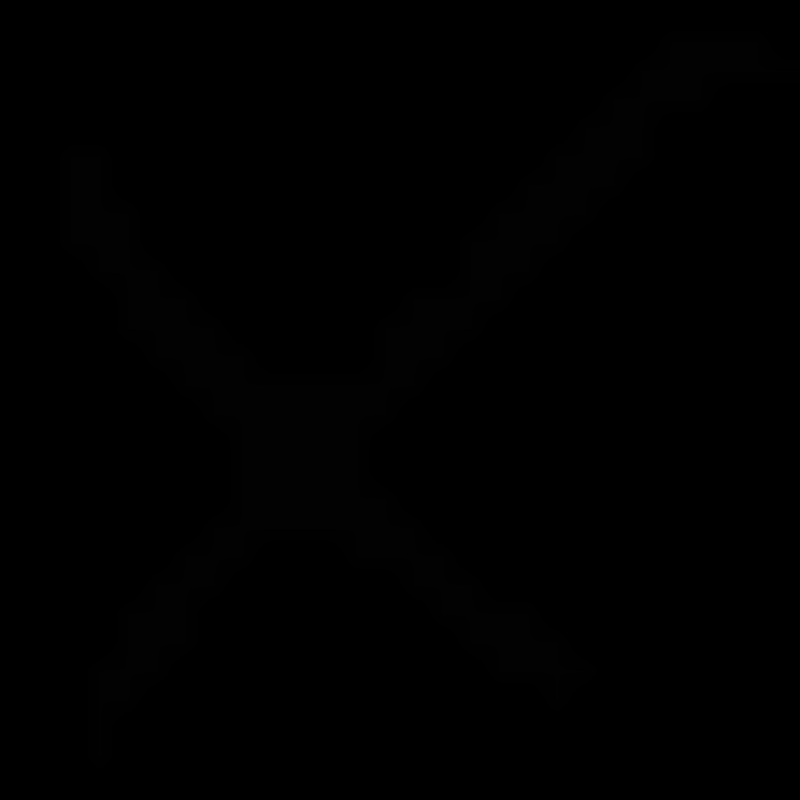

Target label:  15
Predicted label:  15


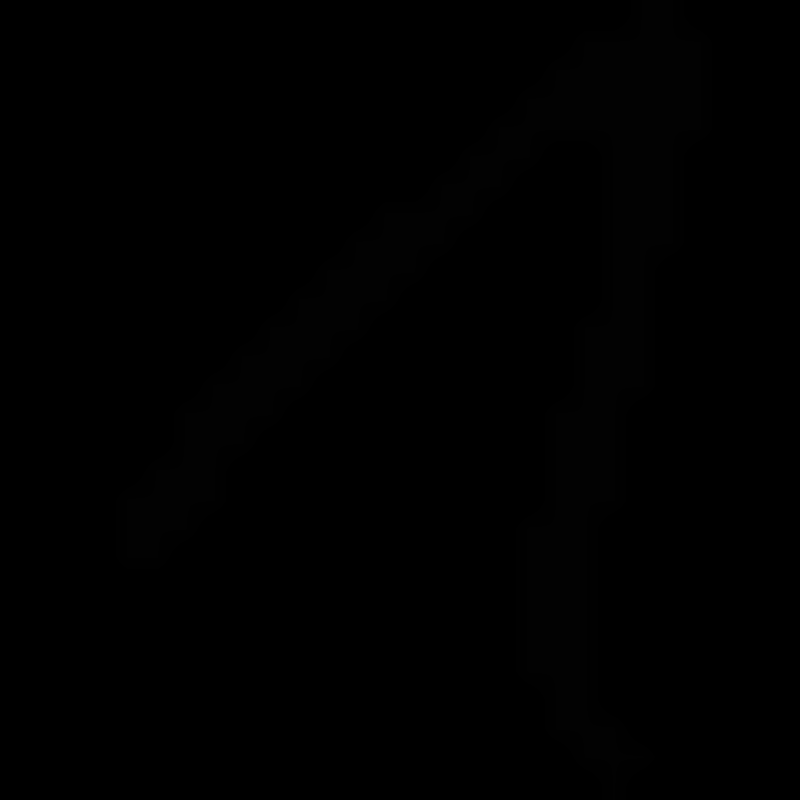

Target label:  1
Predicted label:  1


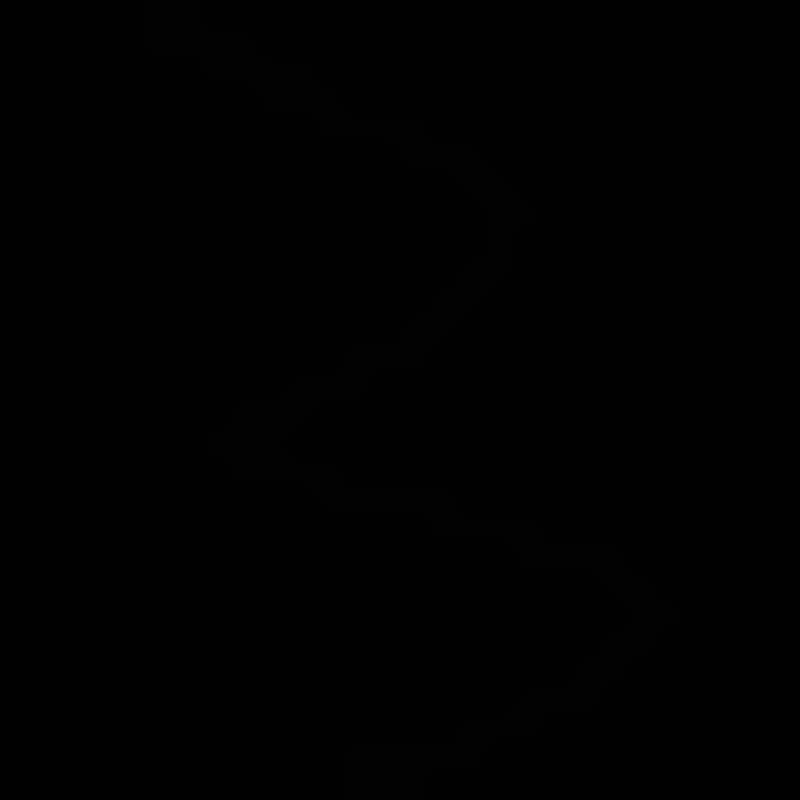

Target label:  3
Predicted label:  16


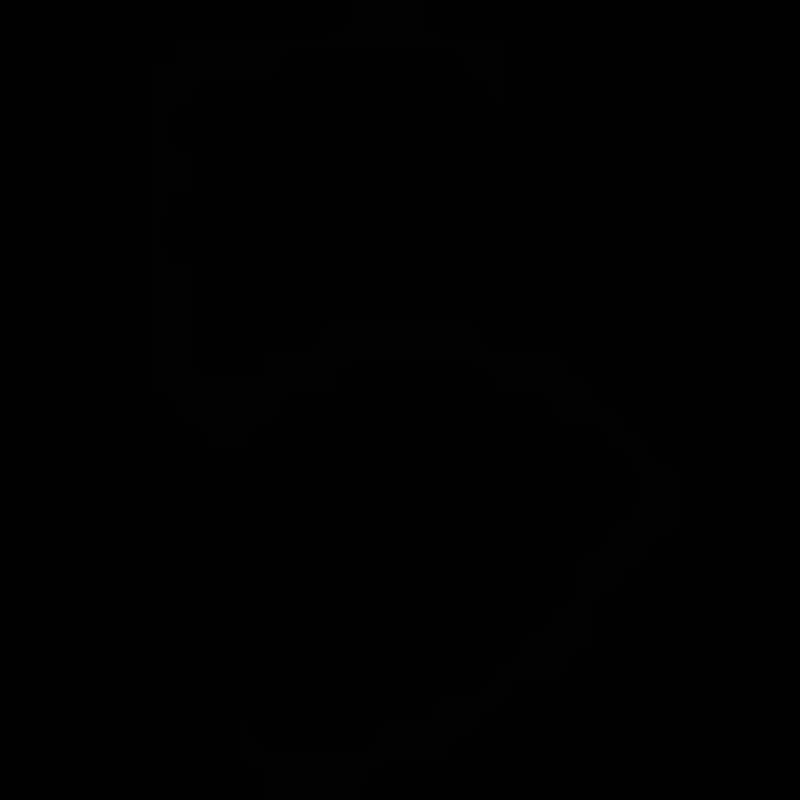

Target label:  5
Predicted label:  5


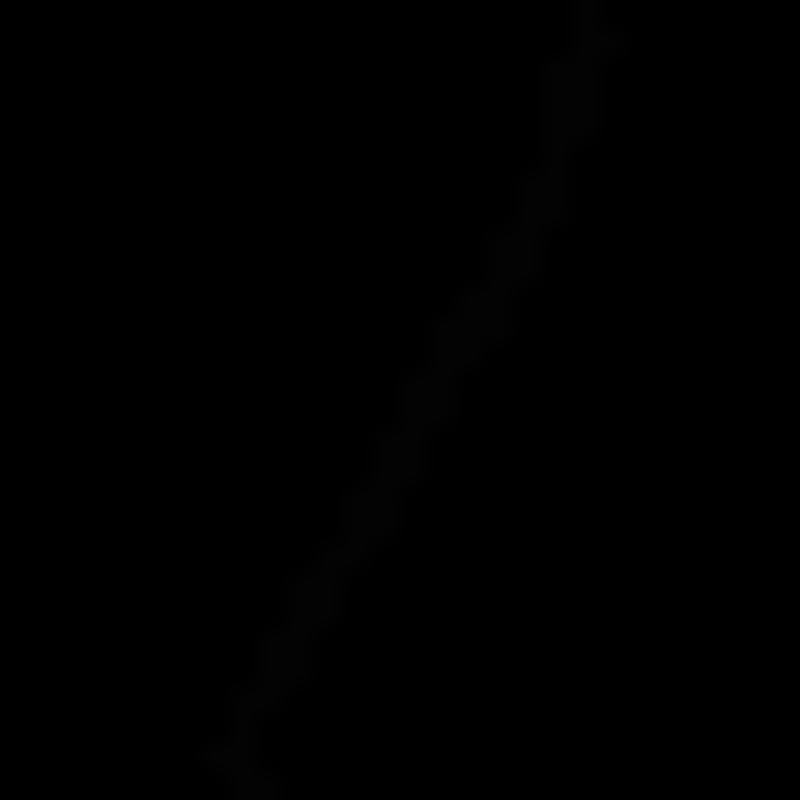

Target label:  12
Predicted label:  12


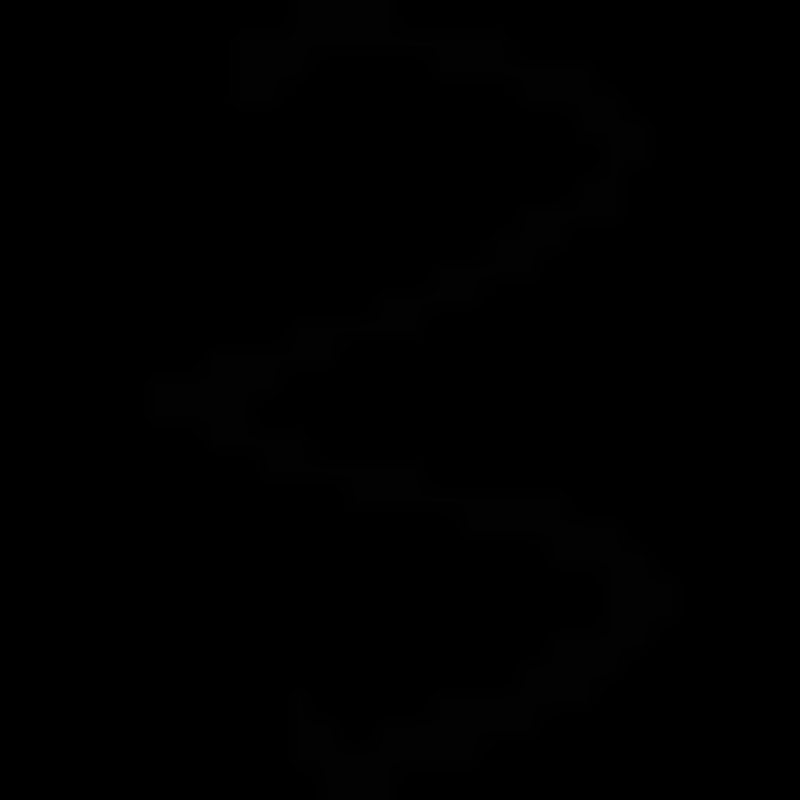

Target label:  3
Predicted label:  3


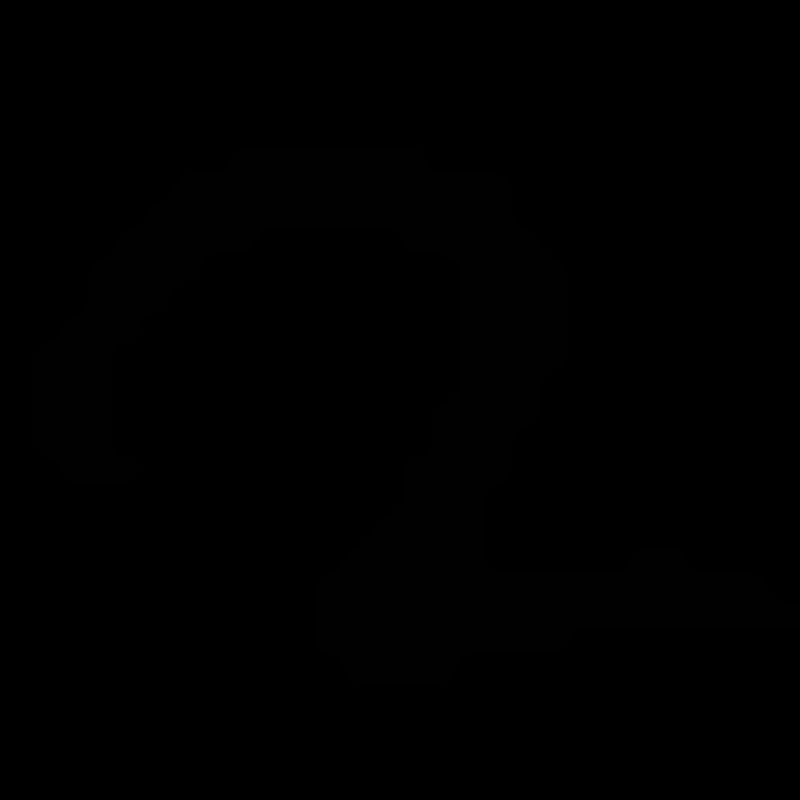

Target label:  2
Predicted label:  17


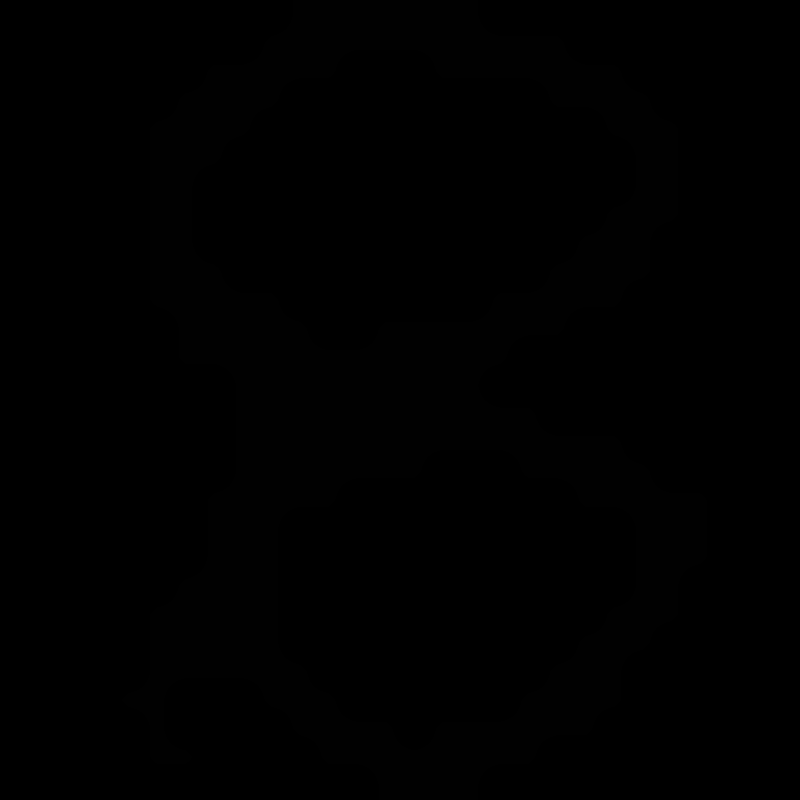

Target label:  8
Predicted label:  8


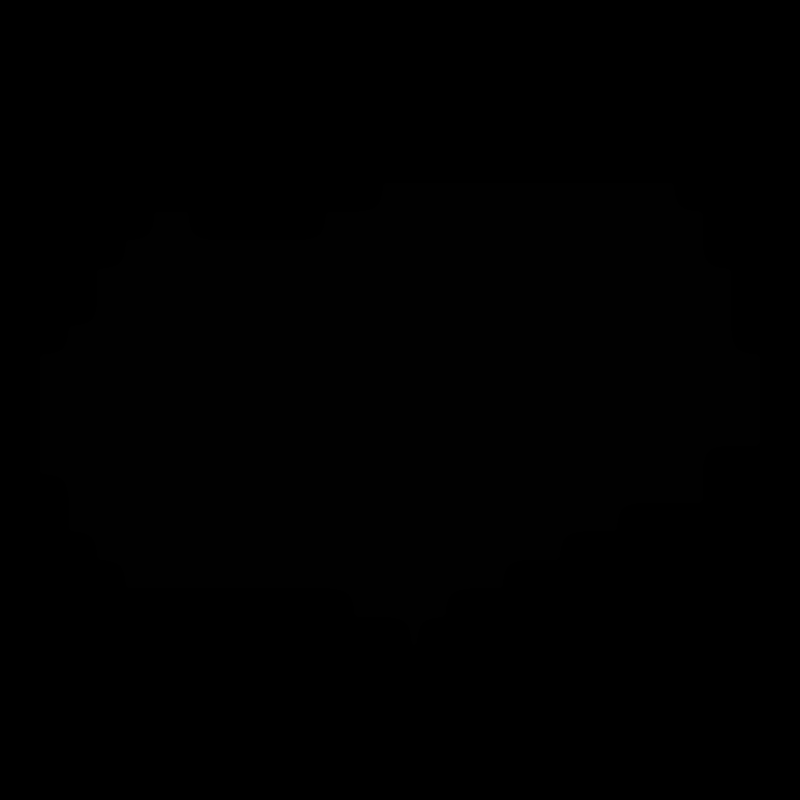

Target label:  13
Predicted label:  13


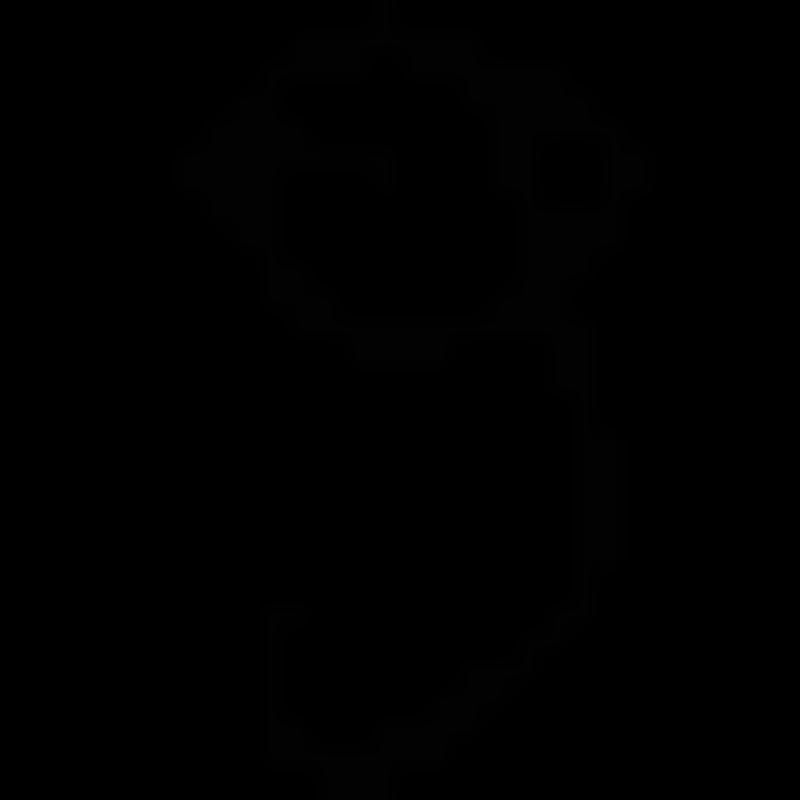

Target label:  9
Predicted label:  9


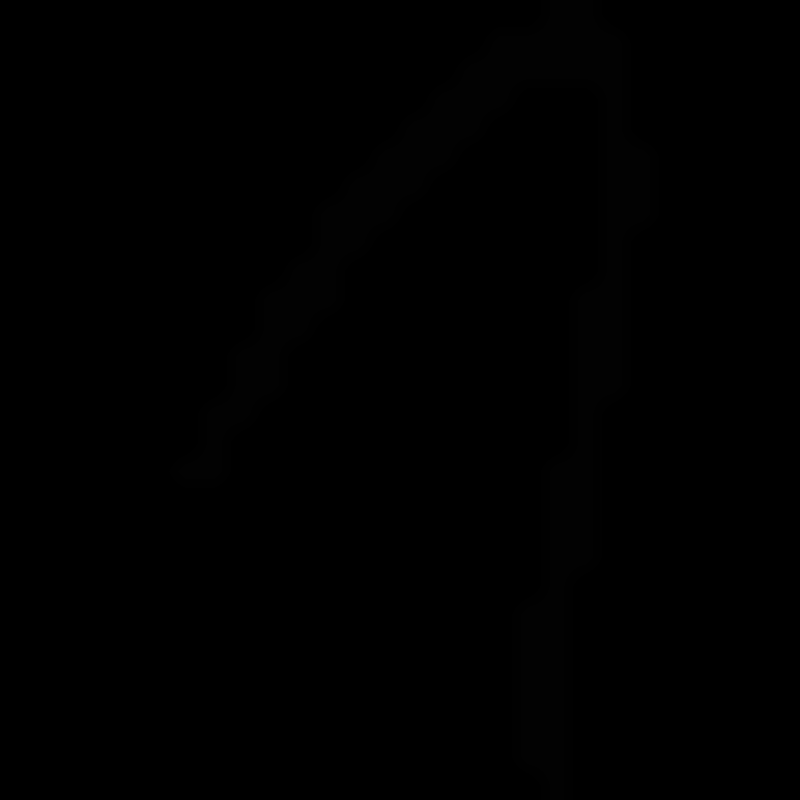

Target label:  1
Predicted label:  1


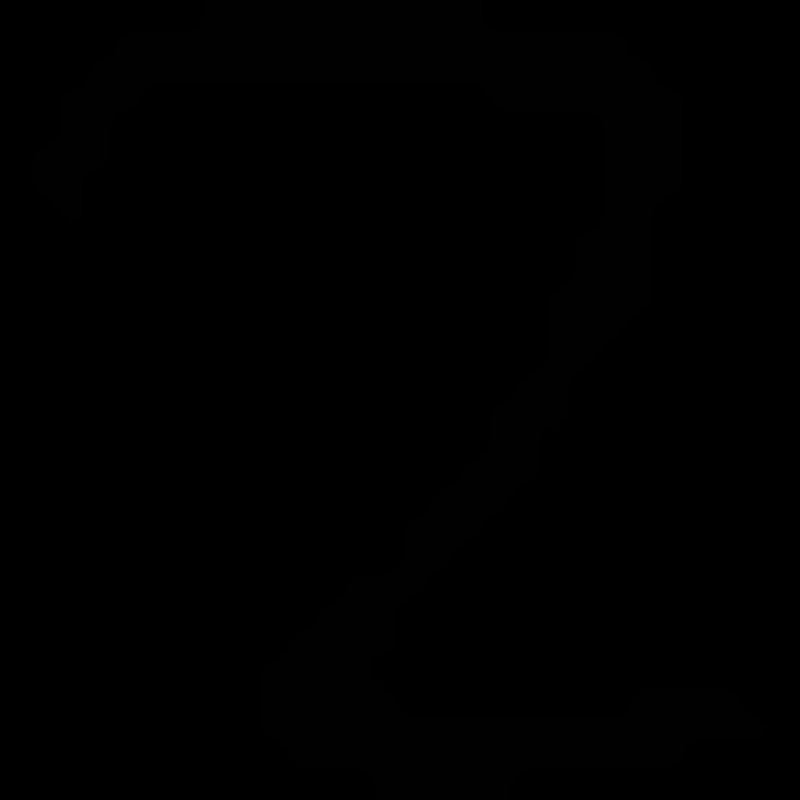

Target label:  2
Predicted label:  2


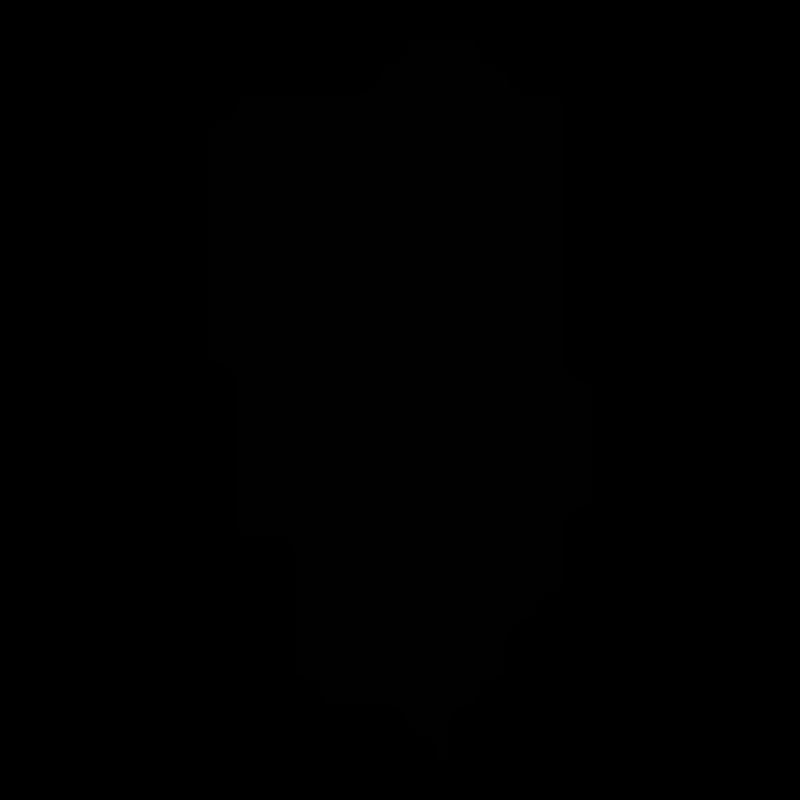

Target label:  13
Predicted label:  13


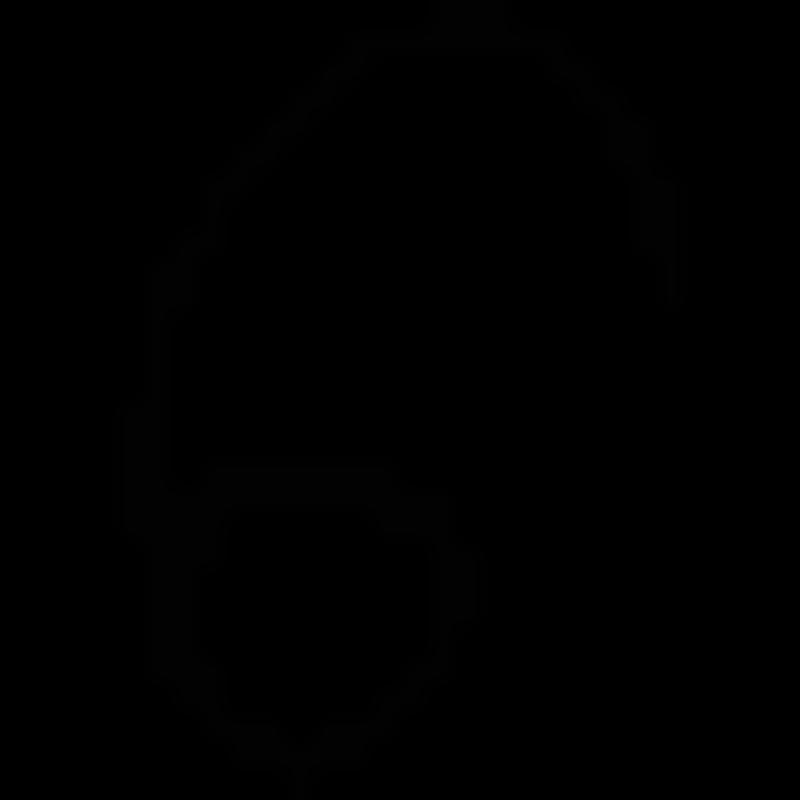

Target label:  6
Predicted label:  6

Test set: Average loss: 0.6722, Accuracy: 2423.0/2700 (90%)



In [ ]:
"""
TESTING
"""
def evaluate(network, testloader, criterion, device):    
    test_loss, loss = 0, 0
    test_correct, correct = 0, 0

    #set network to eval mode 
    network.to(device)
    network.eval()

    #testing the model
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)

            #predicting output using model 
            output = network(data)
            predicted_label = output.cpu().data.max(1, keepdim=True)[1].item() 
        
            #update loss
            loss = criterion(output, target)
            test_loss += loss.item()

            #calculate correct 
            correct = (output.argmax(1) == target).type(torch.float).sum().item()
            test_correct += correct

            #randomly show test image and prediction 
            if (random.randint(0, 100) == 25):
                test_image = data.cpu().data.squeeze().numpy()
                test_image = cv2.resize(test_image, (800, 800))
                cv2_imshow(test_image)                              #use this if using google colab (google colab cv_imshow has problem showcasing the pictures as they're all black)
                #cv2.imshow("Test image", test_image)               #otherwise use this 
                print("Target label: ", target.cpu().item())
                print("Predicted label: ", predicted_label)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

    
    #calculate average loss
    test_loss = test_loss / len(testloader.dataset)
    
    #printing 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, 
                                                                                test_correct, 
                                                                                len(testloader.dataset), 
                                                                                100. * test_correct / len(testloader.dataset)))

#getting previous internal state of model 
#model = Student(num_classes=num_classes)
#model.load_state_dict(torch.load("model_new_student.pth"))

#testing the students and the teacher
evaluate(new_student, testloader, criterion, device)
evaluate(teacher, testloader, criterion, device)
evaluate(student, testloader, criterion, device)


In [ ]:
"""
Helper functions
"""
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
  
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
  
    # handle if we are sorting against the y-coordinate rather than the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
  
    # construct the list of bounding boxes and sort them from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
  
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


#function to convert image to tensor 
def convert_to_tensor(image):
    image = cv2.resize(image, (28, 28))      

    #transform to tensor 
    trans = transforms.Compose([transforms.ToTensor()])
    tensor_image = trans(image)

    #normalizing tensor
    mean, std = torch.mean(tensor_image), torch.std(tensor_image)
    normalize = transforms.Normalize(mean, std)
    tensor_image = normalize(tensor_image)

    return tensor_image

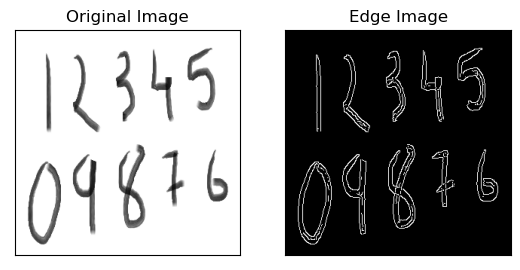

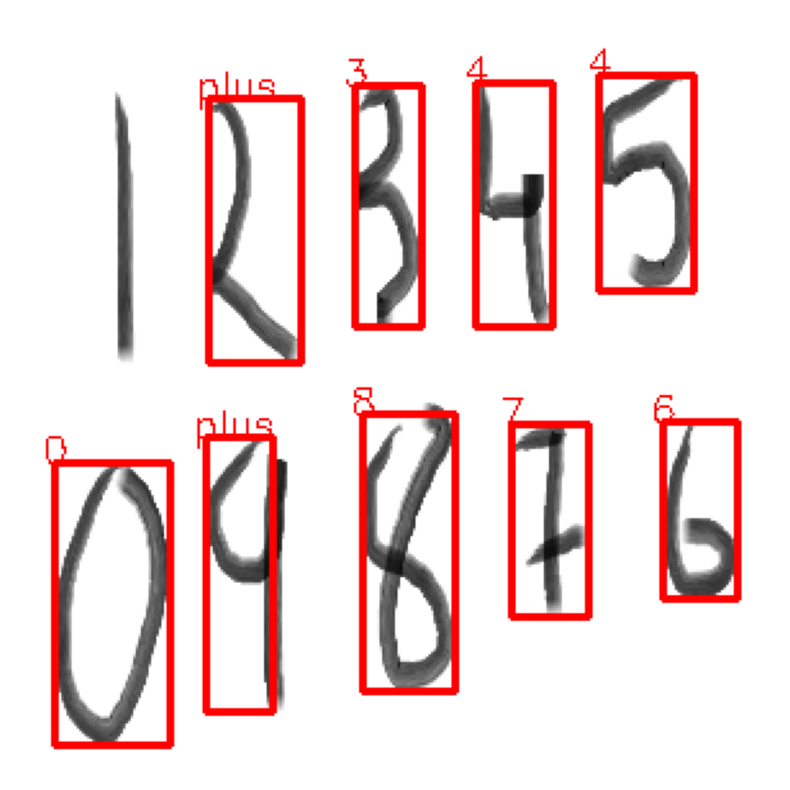

In [ ]:
"""
TEST IMAGE ON EXPRESSION
"""
def pipeline_expression(image_path, network):
    #predictions 
    predictions = []

    #set network to testing mode 
    network.to(device)
    network.eval()
    
    #process main image 
    image = cv2.imread(image_path)
    image = cv2.resize(image,(300, 300))                    #resize expression image
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    #grayscale image 
    edged = cv2.Canny(image_gray, 30, 150)                  #detect edges (min val: 30, max val: 150 - maybe change later?)

    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   #detecting contours 
    contours = imutils.grab_contours(contours)                                              #only getting the contours
    contours = sort_contours(contours, method="left-to-right")[0]                           #sorting from left to right

    #plotting edged image 
    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edged, cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
     
    #plot contours
    #cv2.drawContours(image, contours, -1, (0,255,0), 3)
    #cv2.imshow("title", image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    
    with torch.no_grad():
        #converting contour -> image -> tensor
        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)  #getting bounding boxes

            #determining the dimensions of the padded image 
            if 20 <= w and 30 <= h:
                roi = image_gray[y:y+h, x:x+w]
                thresh = cv2.threshold(roi, 100, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                (th, tw) = thresh.shape

                if tw > th:
                    thresh = imutils.resize(thresh, width=28)

                if th > tw:
                    thresh = imutils.resize(thresh, height=28)
                
                (th, tw) = thresh.shape

                dx = int(max(0, 28 - tw) / 2.0)
                dy = int(max(0, 28 - th) / 2.0)

                #creates border around image - output is an image
                padded_image = cv2.copyMakeBorder(thresh, 
                                                top=dy, 
                                                bottom=dy, 
                                                left=dx, 
                                                right=dx, 
                                                borderType=cv2.BORDER_CONSTANT, 
                                                value=(0, 0, 0))
                
            
                #prints padded images 
                #cv2.imshow("Padded", padded_image)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
        
                #convert images to tensors
                tensor_image = convert_to_tensor(padded_image)  #image dimensions: [1, 28, 28]
                tensor_image = tensor_image.unsqueeze(0)        #image dimensions: [1, 1, 28, 28]
                tensor_image = tensor_image.to(device)
                
                #predict output
                output = network(tensor_image)
                predicted_label = output.data.max(1, keepdim=True)[1].item()

                #convert and store
                label = INV_LABELS_DICS[predicted_label]
                predictions.append(label)

                #add rectangles and prediction to the image
                cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(image, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
    
    #printing image with bounding boxes
    figure = plt.figure(figsize=(10,10))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    return predictions
    

"""
Testing the pipeline
"""
#getting pretrained model of student 
model = Student(num_classes=num_classes)
model.load_state_dict(torch.load("model_new_student.pth"))

#test images
test_image_path1 = "test1.png"
test_image_path2 = "test2.png"
test_image_path3 = "test3.png"
test_image_path4 = "test4.png"
test_image_path5 = "test5.png"
test_image_path6 = "test6.png"
test_image_path7 = "test7.png"
test_image_path9 = "test9.png"

#testing test images 
predictions1 = pipeline_expression(test_image_path1, model)
predictions2 = pipeline_expression(test_image_path2, model)
predictions3 = pipeline_expression(test_image_path3, model)
predictions4 = pipeline_expression(test_image_path4, model)
predictions5 = pipeline_expression(test_image_path5, model)
predictions6 = pipeline_expression(test_image_path6, model)
predictions7 = pipeline_expression(test_image_path7, model)
predictions9 = pipeline_expression(test_image_path9, model)



In [ ]:
"""
CALCULATOR METHOD
"""
#letters in dataset
x, y, z, w = symbols('x y z w')


def calculator(predictions):
    e = ""                      #variable to hold final handwritten expression 
    unknown_variable = False    #keep track of unknown variable
    i = 0                       #counter

    while i < (len(predictions)):
        #check for unknown variable in expression 
        if predictions[i] == 'x' or predictions[i] =='y' or predictions[i] =='z' or predictions[i] =='w':
          unknown_variable = True

        #add plus 
        if predictions[i] == 'plus':
            e += '+'

        #add equal sign if two minus sign is next to each other
        elif predictions[i] == 'minus'and predictions[i + 1] =='minus':
          e += '='
          i += 1
        
        #add minus 
        elif predictions[i] == 'minus':
            e += '-'
        
        #add division
        elif predictions[i] == 'slash':
            e += '/'
        
        #add multiplication 
        elif predictions[i] == 'dot':
            e += '*'
        
        #add number 
        else:
            e += predictions[i]
        
        i += 1

    #if there is an unknown letter in expression, then use sympify/solve functions to calculate expression 
    if unknown_variable == True:
       eq = ''.join(e)
       print("The equation is:",eq)
       gfg_exp = sympify("Eq(" + eq.replace("=", ",") + ")")

       # Use sympy.integrate() method
       intr = solve(gfg_exp, x, y, z, w,dict=True)
       print("The solution is {}".format(intr))

    #otherwise simply use eval function to calculate expression 
    else:
      result = eval(e)
      print("Expression: ", e)
      print("Result: ", result)


#testing the calculator on predictions 
calculator(predictions1)
calculator(predictions2)
calculator(predictions3)
calculator(predictions4)
calculator(predictions5)
calculator(predictions6)
calculator(predictions7)



Expression:  0++384746
Result:  384746


: 

### Sources
The following implementation uses the same sources presented in "project.ipynb". Additional sources are stated below.

**Knowledge Distillation** 
- https://github.com/microsoft/nni/blob/c31d2574cb418acfb80c17bb2bd03531556325bd/examples/model_compress/pruning/legacy/finetune_kd_torch.py#L97
- https://het-shah.github.io/blog/2020/Knowledge-Distillation/
- https://josehoras.github.io/knowledge-distillation/